In [1]:
import os
import json
import time
import random
import requests
import re
from typing import List, Dict, Tuple
import pandas as pd
import networkx as nx
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from openai import OpenAI
import spacy
import faiss
import pickle
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from dotenv import load_dotenv

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

load_dotenv()
os.environ["OPENROUTER_API_KEY"] = os.getenv('OPENROUTER_API_KEY')
os.environ["SERPAPI_API_KEY"] = os.getenv('SERPER_API_KEY')

client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"])
embedder = SentenceTransformer('all-MiniLM-L6-v2')


global_kg = nx.DiGraph()         
index      = None                
nodes      = []                   
node_texts = []                   

print("Setup complete!")

E:\research paper\Web-Search-Only Knowledge Graphs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E:\research paper\Web-Search-Only Knowledge Graphs\venv\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Setup complete!


In [2]:
domain_topic = "Cancer Research and Diagnosis"

prompt = f"""
List 5 most credible websites for factual information on '{domain_topic}'.
Return **only** a JSON array in the exact format:
[{{"site": "example.com", "credibility_reason": "short reason"}}]
"""

response = client.chat.completions.create(
    model="meta-llama/llama-3-8b-instruct",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2,
    max_tokens=500
)

raw = response.choices[0].message.content.strip()
json_match = re.search(r'\[\s*{.*?}\s*\]', raw, re.DOTALL)

if json_match:
    try:
        websites = json.loads(json_match.group())
    except json.JSONDecodeError:
        websites = []
else:
    websites = []

if not websites:
    websites = [
        {"site": "cancer.gov",               "credibility_reason": "U.S. National Cancer Institute"},
        {"site": "pubmed.ncbi.nlm.nih.gov",  "credibility_reason": "Peer-reviewed medical literature"},
        {"site": "ascopubs.org",             "credibility_reason": "American Society of Clinical Oncology"},
        {"site": "nature.com/cancer",        "credibility_reason": "High-impact oncology journal"},
        {"site": "who.int/cancer",           "credibility_reason": "World Health Organization"}
    ]

prioritized_sources = [
    {"site": w["site"], "priority": i+1, "credibility": w["credibility_reason"]}
    for i, w in enumerate(websites)
]

df_sources = pd.DataFrame(prioritized_sources)
df_sources

,site,priority,credibility
0,cancer.gov,1,Official website of the National Cancer Instit...
1,mayoclinic.org,2,Established medical organization with a strong...
2,cancer.org,3,"Website of the American Cancer Society, a lead..."
3,nccn.org,4,"National Comprehensive Cancer Network, a non-p..."
4,emedicine.medscape.com,5,Peer-reviewed medical journal and online resou...


In [3]:
import pickle
import tempfile
import shutil
from pathlib import Path
import time
import json

CACHE_FILE = Path("search_cache.pkl")
search_cache = {}
if CACHE_FILE.exists():
    try:
        with open(CACHE_FILE, "rb") as f:
            search_cache = pickle.load(f)
        print(f"Loaded {len(search_cache)} cached searches from {CACHE_FILE}")
    except Exception as e:
        print(f"Cache load failed: {e}. Starting fresh.")

SERP_URL = "https://google.serper.dev/search"

def web_search(query: str, site: str = None, num_results: int = 5) -> List[Dict]:
    cache_key = f"{query}|||{site or 'None'}"
    if cache_key in search_cache:
        return search_cache[cache_key]
    
    full_query = f"{query} site:{site}" if site else query
    payload = {"q": full_query, "num": num_results}
    headers = {
        "X-API-KEY": os.environ["SERPAPI_API_KEY"],
        "Content-Type": "application/json"
    }
    
    try:
        resp = requests.post(SERP_URL, json=payload, headers=headers, timeout=20)
        resp.raise_for_status()
        data = resp.json()
        results = []
        for r in data.get('organic', [])[:num_results]:
            results.append({
                "title": r['title'],
                "url": r['link'],
                "snippet": r['snippet'],
                "site": site,
                "query": query,
                "date": r.get('date', time.strftime('%Y-%m-%d'))
            })
        search_cache[cache_key] = results
        
        # --- Atomic save ---
        tmp = CACHE_FILE.with_suffix('.tmp')
        with open(tmp, "wb") as f:
            pickle.dump(search_cache, f)
        shutil.move(tmp, CACHE_FILE)
        
        print(f"Saved: {len(results)} results | {full_query[:60]}...")
        return results
    except Exception as e:
        print(f"Failed: {full_query[:60]}... | {e}")
        return []

cancer_queries = [
    "types of lung cancer and their characteristics",
    "breast cancer diagnosis accuracy with AI",
    "colorectal cancer screening methods",
    "prostate cancer biomarkers",
    "pancreatic cancer early detection challenges",
    "skin cancer melanoma vs basal cell",
    "ovarian cancer symptoms and diagnosis",
    "leukemia types and treatment",
    "brain cancer glioblastoma prognosis",
    "thyroid cancer risk factors"
]

final_test_query = "How does AI improve cancer diagnosis accuracy across different cancer types?"

top_5_sites = [src["site"] for src in prioritized_sources[:5]]
print(f"Using {len(top_5_sites)} credible sites: {top_5_sites}")

all_results = []
total_expected = len(cancer_queries) * len(top_5_sites) * 5  # 10 × 5 × 5 = 250

print(f"\nStarting search: {len(cancer_queries)} queries × {len(top_5_sites)} sites × 5 results = {total_expected} URLs\n")

for query in cancer_queries:
    print(f"\nQuery: {query}")
    for site in top_5_sites:
        results = web_search(query, site=site, num_results=5)
        all_results.extend(results)
        time.sleep(1)  # Be respectful to API

print(f"\nFinal Test Query: {final_test_query}")
for site in top_5_sites:
    results = web_search(final_test_query, site=site, num_results=5)
    all_results.extend(results)
    time.sleep(0.8)

summary = {
    "total_urls": len(all_results),
    "unique_urls": len({r["url"] for r in all_results}),
    "cache_size": len(search_cache),
    "queries_run": len(cancer_queries) + 1,
    "sites_used": top_5_sites
}

with open("search_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*80)
print("SEARCH COMPLETE!")
print(f"Total URLs collected: {summary['total_urls']}")
print(f"Unique URLs: {summary['unique_urls']}")
print(f"Cache entries: {summary['cache_size']}")
print(f"Results saved to: search_cache.pkl")
print(f"Summary saved to: search_summary.json")
print("="*80)

if all_results:
    print("\nExample result:")
    print(json.dumps(all_results[0], indent=2))

Using 5 credible sites: ['cancer.gov', 'mayoclinic.org', 'cancer.org', 'nccn.org', 'emedicine.medscape.com']

Starting search: 10 queries × 5 sites × 5 results = 250 URLs


Query: types of lung cancer and their characteristics
Saved: 5 results | types of lung cancer and their characteristics site:cancer.g...
Saved: 5 results | types of lung cancer and their characteristics site:mayoclin...
Saved: 5 results | types of lung cancer and their characteristics site:cancer.o...
Saved: 5 results | types of lung cancer and their characteristics site:nccn.org...
Saved: 5 results | types of lung cancer and their characteristics site:emedicin...

Query: breast cancer diagnosis accuracy with AI
Saved: 5 results | breast cancer diagnosis accuracy with AI site:cancer.gov...
Saved: 5 results | breast cancer diagnosis accuracy with AI site:mayoclinic.org...
Saved: 5 results | breast cancer diagnosis accuracy with AI site:cancer.org...
Saved: 5 results | breast cancer diagnosis accuracy with AI site:ncc

In [4]:
import undetected_chromedriver as uc
import cloudscraper
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from urllib.parse import urljoin, urlparse
import re
import time
import random
from typing import List

def _get_chrome_major_version():
    try:
        output = subprocess.check_output(
            r'reg query "HKEY_CURRENT_USER\Software\Google\Chrome\BLBeacon" /v version',
            stderr=subprocess.DEVNULL,
            text=True
        )
        match = re.search(r"(\d+)\.", output)
        if match:
            return int(match.group(1))
    except:
        pass
    return None
def _get_stealth_driver():
    options = uc.ChromeOptions()
    options.add_argument("--headless=new")          
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--disable-images")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--disable-extensions")
    options.add_argument("--disable-plugins")
    options.add_argument("--disable-logging")
    options.add_argument("--log-level=3")
    options.add_argument("--blink-settings=imagesEnabled=false")

    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
    ]
    options = uc.ChromeOptions()
    driver = uc.Chrome(options=options, use_subprocess=True)
    
    driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
        "source": """
            Object.defineProperty(navigator, 'webdriver', {get: () => false});
            window.chrome = { runtime: {}, app: {}, webstore: {} };
            Object.defineProperty(navigator, 'languages', {get: () => ['en-US', 'en']});
            Object.defineProperty(navigator, 'plugins', {get: () => [1, 2, 3]});
        """
    })
    return driver
    
scraper = cloudscraper.create_scraper(
    browser={'browser': 'chrome', 'platform': 'windows', 'mobile': False},
    delay=10
)

def scrape_content(
    url: str,
    topic_keywords: List[str] = None,
    max_internal: int = 2,
    max_chars: int = 6000
) -> str:
    if topic_keywords is None:
        topic_keywords = ["AI", "hallucination", "medical", "diagnosis", "scribe", "accuracy", "risk"]

    driver = None
    html = ""
    attempts = 0
    max_attempts = 3

    while attempts < max_attempts and not html:
        attempts += 1
        try:
            driver = _get_stealth_driver()
            driver.set_page_load_timeout(20)
            driver.get(url)
            time.sleep(random.uniform(2, 4))  

            WebDriverWait(driver, 18).until(
                lambda d: any(
                    kw.lower() in d.page_source.lower()
                    for kw in topic_keywords
                ) or "verifying" not in d.page_source.lower()
            )
            html = driver.page_source
            print(f"Selenium success (attempt {attempts}): {url[:50]}...")
            break
        except Exception as e:
            print(f"Selenium failed (attempt {attempts}): {e}")
            time.sleep(3)
        finally:
            if driver:
                driver.quit()
                driver = None

    if not html or "verifying you are human" in html.lower():
        try:
            print(f"Cloudscraper fallback: {url[:50]}...")
            response = scraper.get(url, timeout=20)
            html = response.text
        except Exception as e:
            print(f"Cloudscraper failed: {e}")
            return ""

    soup = BeautifulSoup(html, "html.parser")
    for sel in ["script", "style", "nav", "footer", "aside", ".ad", ".popup", "#cookie", ".modal"]:
        for el in soup.select(sel):
            el.decompose()

    parts = []

    for p in soup.find_all("p"):
        txt = p.get_text(strip=True)
        if txt and len(txt) > 20 and any(kw.lower() in txt.lower() for kw in topic_keywords):
            parts.append(txt)

    for ul in soup.find_all(["ul", "ol"]):
        items = [li.get_text(strip=True) for li in ul.find_all("li")]
        if items and any(any(kw.lower() in i.lower() for kw in topic_keywords) for i in items):
            parts.append(" • ".join(items))

    for tbl in soup.find_all("table"):
        rows = [[c.get_text(strip=True) for c in r.find_all(["td", "th"])] for r in tbl.find_all("tr")]
        if rows and any(any(kw.lower() in " ".join(r).lower() for kw in topic_keywords) for r in rows):
            parts.append("|".join(["|".join(row) for row in rows[:5]]))

    for div in soup.find_all("div", class_=re.compile(r"content|article|body|post|story", re.I)):
        txt = div.get_text(strip=True)
        if txt and any(kw.lower() in txt.lower() for kw in topic_keywords):
            parts.append(txt[:1400])

    text = " ".join(parts)

    if max_internal > 0 and len(text) > 300:
        try:
            driver = _get_stealth_driver()
            driver.get(url)
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
            soup_links = BeautifulSoup(driver.page_source, "html.parser")
            base = urlparse(url)
            links = set()

            for a in soup_links.find_all("a", href=True):
                href = a["href"]
                if href.startswith("/") or base.netloc in href:
                    full = urljoin(url, href)
                    if any(kw.lower() in a.get_text().lower() for kw in topic_keywords):
                        links.add(full)

            for link in list(links)[:max_internal]:
                try:
                    driver.get(link)
                    time.sleep(1.5)
                    sub_soup = BeautifulSoup(driver.page_source, "html.parser")
                    extra = [p.get_text(strip=True) for p in sub_soup.find_all("p")[:6] if len(p.get_text()) > 30]
                    text += " " + " ".join(extra)
                except:
                    continue
        except:
            pass
        finally:
            if driver:
                driver.quit()

    if len(text) > 1000:
        try:
            prompt = f"""
            Extract only factual sentences about medical AI, hallucinations, scribes, accuracy, or risks.
            Remove ads, navigation, and boilerplate.
            Input: {text[:3000]}
            """
            resp = client.chat.completions.create(
                model="meta-llama/llama-3-8b-instruct",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=1000
            )
            filtered = resp.choices[0].message.content.strip()
            if len(filtered) > 200:
                text = filtered
        except Exception as e:
            print(f"LLM filter error: {e}")

    return text[:max_chars].strip()

In [5]:
import pickle
import os
from pathlib import Path
from tqdm import tqdm
import json
import time

CACHE_FILE = Path("search_cache.pkl")
if not CACHE_FILE.exists():
    raise FileNotFoundError("search_cache.pkl not found! Run Cell 4 first.")

with open(CACHE_FILE, "rb") as f:
    search_cache = pickle.load(f)

print(f"Loaded {len(search_cache)} cached searches → extracting URLs...")

url_records = []
seen_urls = set()

for (query_site_key, results) in search_cache.items():
    query, site = query_site_key.split("|||", 1)
    site = site if site != "None" else None
    for res in results:
        url = res["url"]
        if url in seen_urls:
            continue
        seen_urls.add(url)
        url_records.append({
            "url": url,
            "title": res.get("title", ""),
            "query": query,
            "site": site or res.get("site", "unknown"),
            "date": res.get("date", "unknown"),
            "snippet": res.get("snippet", "")
        })

print(f"Found {len(url_records)} unique URLs to scrape")

SCRAPED_FILE = Path("scraped_content.pkl")
scraped_cache = {}
if SCRAPED_FILE.exists():
    try:
        with open(SCRAPED_FILE, "rb") as f:
            scraped_cache = pickle.load(f)
        print(f"Loaded {len(scraped_cache)} already scraped pages")
    except Exception as e:
        print(f"Failed to load scraped cache: {e}")

to_scrape = [r for r in url_records if r["url"] not in scraped_cache]
print(f"Need to scrape: {len(to_scrape)} / {len(url_records)}")

scraped_list = list(scraped_cache.values())  # keep old ones

for record in tqdm(to_scrape, desc="Scraping URLs", unit="page"):
    url = record["url"]
    try:
        text = scrape_content(url, topic_keywords=["cancer", "diagnosis", "AI", "accuracy", "risk", "hallucination"])
        if text.strip():
            record["text"] = text
            record["scraped_at"] = time.strftime("%Y-%m-%d %H:%M:%S")
            scraped_list.append(record)
            scraped_cache[url] = record
        else:
            record["text"] = ""
            record["error"] = "empty_content"
            scraped_list.append(record)
            scraped_cache[url] = record
    except Exception as e:
        record["text"] = ""
        record["error"] = str(e)
        scraped_list.append(record)
        scraped_cache[url] = record
    time.sleep(1.2)  # Be kind to servers

with open(SCRAPED_FILE, "wb") as f:
    pickle.dump(scraped_cache, f)

summary = {
    "total_urls_scraped": len(scraped_cache),
    "successful_scrapes": len([r for r in scraped_cache.values() if r.get("text", "")]),
    "failed_scrapes": len([r for r in scraped_cache.values() if not r.get("text", "")]),
    "file": str(SCRAPED_FILE),
    "saved_at": time.strftime("%Y-%m-%d %H:%M:%S")
}

with open("scraping_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*80)
print("SCRAPING COMPLETE!")
print(f"Total URLs scraped: {summary['total_urls_scraped']}")
print(f"With content: {summary['successful_scrapes']}")
print(f"Failed/empty: {summary['failed_scrapes']}")
print(f"Data saved to: {SCRAPED_FILE}")
print(f"Summary saved to: scraping_summary.json")
print("="*80)

example = next((r for r in scraped_list if r.get("text")), None)
if example:
    print(f"\nExample: {example['title'][:60]}...")
    print(example["text"][:500] + "...")

Loaded 55 cached searches → extracting URLs...
Found 266 unique URLs to scrape
Need to scrape: 266 / 266


Scraping URLs:   0%|                                                                         | 0/266 [00:00<?, ?page/s]

Selenium success (attempt 1): https://training.seer.cancer.gov/lung/intro/types....


Scraping URLs:   0%|▏                                                              | 1/266 [00:50<3:41:17, 50.10s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/lung...


Scraping URLs:   1%|▍                                                              | 2/266 [01:35<3:28:42, 47.44s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/lung/patient/non-smal...


Scraping URLs:   1%|▋                                                              | 3/266 [02:18<3:17:49, 45.13s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/lung/hp/non-small-cel...


Scraping URLs:   2%|▉                                                              | 4/266 [03:11<3:30:43, 48.26s/page]

Selenium success (attempt 1): https://seer.cancer.gov/tools/mphrules/2007/lung/t...


Scraping URLs:   2%|█▏                                                             | 5/266 [03:28<2:41:49, 37.20s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/lun...


Scraping URLs:   2%|█▍                                                             | 6/266 [04:29<3:16:24, 45.33s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/departments-centers/lun...


Scraping URLs:   3%|█▋                                                             | 7/266 [05:13<3:12:44, 44.65s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/lun...
LLM filter error: Connection error.


Scraping URLs:   3%|█▉                                                             | 8/266 [05:57<3:12:10, 44.69s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/disc...


Scraping URLs:   3%|██▏                                                            | 9/266 [06:41<3:09:49, 44.32s/page]

Selenium success (attempt 1): https://mcpress.mayoclinic.org/cancer/different-wa...


Scraping URLs:   4%|██▎                                                           | 10/266 [07:46<3:36:53, 50.84s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/lung-cancer/ab...


Scraping URLs:   4%|██▌                                                           | 11/266 [08:40<3:39:11, 51.57s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/lung-cancer.ht...


Scraping URLs:   5%|██▊                                                           | 12/266 [09:34<3:41:39, 52.36s/page]

Selenium success (attempt 1): https://www.cancer.org/content/dam/cancer-org/canc...


Scraping URLs:   5%|███                                                           | 13/266 [09:47<2:51:13, 40.61s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/lung-cancer/de...


Scraping URLs:   5%|███▎                                                          | 14/266 [10:46<3:13:01, 45.96s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/diagnosis-staging/te...


Scraping URLs:   6%|███▍                                                          | 15/266 [11:31<3:11:54, 45.87s/page]

Selenium success (attempt 1): https://www.nccn.org/professionals/physician_gls/p...


Scraping URLs:   6%|███▋                                                          | 16/266 [11:51<2:38:50, 38.12s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:   6%|███▉                                                          | 17/266 [12:46<2:58:37, 43.04s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:   7%|████▏                                                         | 18/266 [13:03<2:25:24, 35.18s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:   7%|████▍                                                         | 19/266 [13:19<2:00:57, 29.38s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:   8%|████▋                                                         | 20/266 [13:34<1:43:23, 25.22s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/279960-over...


Scraping URLs:   8%|████▉                                                         | 21/266 [14:18<2:05:17, 30.68s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/279960-clin...


Scraping URLs:   8%|█████▏                                                        | 22/266 [15:05<2:25:33, 35.79s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/280104-over...


Scraping URLs:   9%|█████▎                                                        | 23/266 [15:50<2:35:16, 38.34s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/426820-over...


Scraping URLs:   9%|█████▌                                                        | 24/266 [16:33<2:41:02, 39.93s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/279960-diff...


Scraping URLs:   9%|█████▊                                                        | 25/266 [17:19<2:47:29, 41.70s/page]

Selenium success (attempt 1): https://www.cancer.gov/research/infrastructure/art...
LLM filter error: Connection error.


Scraping URLs:  10%|██████                                                        | 26/266 [18:00<2:46:15, 41.57s/page]

Selenium success (attempt 1): https://cdas.cancer.gov/approved-projects/4684/...


Scraping URLs:  10%|██████▎                                                       | 27/266 [18:38<2:41:03, 40.43s/page]

Selenium success (attempt 1): https://www.cancer.gov/about-nci/organization/cbii...


Scraping URLs:  11%|██████▌                                                       | 28/266 [19:15<2:35:53, 39.30s/page]

Selenium success (attempt 1): https://www.cancer.gov/news-events/cancer-currents...


Scraping URLs:  11%|██████▊                                                       | 29/266 [19:55<2:36:32, 39.63s/page]

Selenium success (attempt 1): https://www.cancer.gov/news-events/cancer-currents...


Scraping URLs:  11%|██████▉                                                       | 30/266 [20:35<2:36:46, 39.86s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  12%|███████▏                                                      | 31/266 [21:29<2:52:05, 43.94s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/adva...


Scraping URLs:  12%|███████▍                                                      | 32/266 [22:16<2:54:56, 44.86s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  12%|███████▋                                                      | 33/266 [23:03<2:56:48, 45.53s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2023/11/02/mayo-...


Scraping URLs:  13%|███████▉                                                      | 34/266 [23:55<3:03:57, 47.57s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  13%|████████▏                                                     | 35/266 [24:51<3:12:17, 49.95s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  14%|████████▍                                                     | 36/266 [25:36<3:05:50, 48.48s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  14%|████████▌                                                     | 37/266 [26:18<2:57:43, 46.56s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  14%|████████▊                                                     | 38/266 [27:05<2:57:19, 46.66s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/breast-cancer/...


Scraping URLs:  15%|█████████                                                     | 39/266 [27:50<2:55:10, 46.30s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  15%|█████████▎                                                    | 40/266 [28:35<2:51:57, 45.65s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  15%|█████████▌                                                    | 41/266 [28:51<2:18:16, 36.88s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  16%|█████████▊                                                    | 42/266 [29:07<1:54:25, 30.65s/page]

Selenium success (attempt 1): https://education.nccn.org/sites/default/files/cou...


Scraping URLs:  16%|██████████                                                    | 43/266 [29:26<1:40:29, 27.04s/page]

Selenium success (attempt 1): https://education.nccn.org/breast...


Scraping URLs:  17%|██████████▎                                                   | 44/266 [30:13<2:02:57, 33.23s/page]

Selenium success (attempt 1): https://education.nccn.org/system/files/Final%20Ho...


Scraping URLs:  17%|██████████▍                                                   | 45/266 [30:30<1:44:24, 28.35s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1947145-wor...


Scraping URLs:  17%|██████████▋                                                   | 46/266 [31:21<2:08:09, 34.95s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1947145-dif...


Scraping URLs:  18%|██████████▉                                                   | 47/266 [32:11<2:24:41, 39.64s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1947145-ove...


Scraping URLs:  18%|███████████▏                                                  | 48/266 [33:01<2:35:12, 42.72s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1945498-ove...


Scraping URLs:  18%|███████████▍                                                  | 49/266 [33:51<2:42:05, 44.82s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1947145-cli...


Scraping URLs:  19%|███████████▋                                                  | 50/266 [34:45<2:50:53, 47.47s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/colorectal/screening-...


Scraping URLs:  19%|███████████▉                                                  | 51/266 [35:42<3:00:42, 50.43s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/colorectal/patient/co...


Scraping URLs:  20%|████████████                                                  | 52/266 [36:29<2:55:51, 49.31s/page]

Selenium success (attempt 1): https://progressreport.cancer.gov/detection/colore...


Scraping URLs:  20%|████████████▎                                                 | 53/266 [37:13<2:49:42, 47.80s/page]

Selenium success (attempt 1): https://cisnet.cancer.gov/projections/colorectal/s...


Scraping URLs:  20%|████████████▌                                                 | 54/266 [37:57<2:44:44, 46.62s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/colorectal/hp/colorec...


Scraping URLs:  21%|████████████▊                                                 | 55/266 [38:41<2:41:05, 45.81s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/col...


Scraping URLs:  21%|█████████████                                                 | 56/266 [39:29<2:42:53, 46.54s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/col...


Scraping URLs:  21%|█████████████▎                                                | 57/266 [40:15<2:41:38, 46.40s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2022/03/22/prope...


Scraping URLs:  22%|█████████████▌                                                | 58/266 [41:04<2:43:30, 47.17s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2025/03/11/youre...


Scraping URLs:  22%|█████████████▊                                                | 59/266 [41:55<2:47:06, 48.44s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/col...


Scraping URLs:  23%|█████████████▉                                                | 60/266 [42:42<2:44:24, 47.88s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/colon-rectal-c...


Scraping URLs:  23%|██████████████▏                                               | 61/266 [43:38<2:51:56, 50.32s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/colon-rectal-c...


Scraping URLs:  23%|██████████████▍                                               | 62/266 [44:25<2:47:53, 49.38s/page]

Selenium success (attempt 1): https://www.cancer.org/content/dam/cancer-org/canc...


Scraping URLs:  24%|██████████████▋                                               | 63/266 [44:43<2:14:50, 39.86s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/latest-news/understa...


Scraping URLs:  24%|██████████████▉                                               | 64/266 [45:32<2:23:46, 42.71s/page]

Selenium success (attempt 1): https://www.cancer.org/health-care-professionals/a...


Scraping URLs:  24%|███████████████▏                                              | 65/266 [46:17<2:24:48, 43.23s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  25%|███████████████▍                                              | 66/266 [46:56<2:19:54, 41.97s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  25%|███████████████▌                                              | 67/266 [47:10<1:51:33, 33.64s/page]

Selenium success (attempt 1): https://education.nccn.org/node/79280...


Scraping URLs:  26%|███████████████▊                                              | 68/266 [47:47<1:54:55, 34.82s/page]

Selenium success (attempt 1): https://www.nccn.org/home/news/newsdetails?NewsId=...


Scraping URLs:  26%|████████████████                                              | 69/266 [48:34<2:05:37, 38.26s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  26%|████████████████▎                                             | 70/266 [49:13<2:06:00, 38.57s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/277496-work...


Scraping URLs:  27%|████████████████▌                                             | 71/266 [49:58<2:12:03, 40.63s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/367061-over...


Scraping URLs:  27%|████████████████▊                                             | 72/266 [50:46<2:18:24, 42.80s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1819350-ove...


Scraping URLs:  27%|█████████████████                                             | 73/266 [51:31<2:19:39, 43.42s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/281237-work...


Scraping URLs:  28%|█████████████████▏                                            | 74/266 [52:19<2:23:01, 44.70s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/277496-over...


Scraping URLs:  28%|█████████████████▍                                            | 75/266 [53:04<2:22:51, 44.88s/page]

Selenium success (attempt 1): https://edrn.cancer.gov/data-and-resources/publica...


Scraping URLs:  29%|█████████████████▋                                            | 76/266 [53:35<2:09:08, 40.78s/page]

Selenium success (attempt 1): https://prevention.cancer.gov/news-and-events/blog...


Scraping URLs:  29%|█████████████████▉                                            | 77/266 [54:21<2:13:22, 42.34s/page]

Selenium success (attempt 1): https://edrn.cancer.gov/data-and-resources/publica...


Scraping URLs:  29%|██████████████████▏                                           | 78/266 [54:56<2:05:37, 40.09s/page]

Selenium success (attempt 1): https://edrn.cancer.gov/data-and-resources/protoco...


Scraping URLs:  30%|██████████████████▍                                           | 79/266 [55:29<1:58:13, 37.93s/page]

Selenium success (attempt 1): https://edrn.cancer.gov/data-and-resources/protoco...


Scraping URLs:  30%|██████████████████▋                                           | 80/266 [55:59<1:50:17, 35.58s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/pro...


Scraping URLs:  30%|██████████████████▉                                           | 81/266 [56:43<1:57:33, 38.13s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  31%|███████████████████                                           | 82/266 [57:26<2:01:39, 39.67s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/disc...


Scraping URLs:  31%|███████████████████▎                                          | 83/266 [58:07<2:01:30, 39.84s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/medical-professionals/c...


Scraping URLs:  32%|███████████████████▌                                          | 84/266 [59:07<2:19:30, 45.99s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/on-o...


Scraping URLs:  32%|███████████████████▊                                          | 85/266 [59:49<2:15:27, 44.90s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/diagnosis-staging/te...


Scraping URLs:  32%|███████████████████▍                                        | 86/266 [1:00:35<2:15:11, 45.07s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  33%|███████████████████▌                                        | 87/266 [1:01:21<2:15:26, 45.40s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/prostate-cance...


Scraping URLs:  33%|███████████████████▊                                        | 88/266 [1:02:19<2:25:51, 49.17s/page]

Selenium success (attempt 1): https://www.cancer.org/content/dam/cancer-org/canc...


Scraping URLs:  33%|████████████████████                                        | 89/266 [1:02:38<1:58:37, 40.21s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  34%|████████████████████▎                                       | 90/266 [1:03:30<2:08:29, 43.80s/page]

Selenium success (attempt 1): https://www.nccn.org/compendia-templates/compendia...


Scraping URLs:  34%|████████████████████▌                                       | 91/266 [1:04:20<2:12:35, 45.46s/page]

Selenium success (attempt 1): https://education.nccn.org/node/94251...


Scraping URLs:  35%|████████████████████▊                                       | 92/266 [1:05:04<2:10:20, 44.94s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  35%|████████████████████▉                                       | 93/266 [1:05:22<1:46:46, 37.03s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  35%|█████████████████████▏                                      | 94/266 [1:06:08<1:53:43, 39.67s/page]

Selenium success (attempt 1): https://education.nccn.org/node/77390...


Scraping URLs:  36%|█████████████████████▍                                      | 95/266 [1:06:50<1:54:47, 40.28s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1967731-ove...


Scraping URLs:  36%|█████████████████████▋                                      | 96/266 [1:07:40<2:02:36, 43.28s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/458011-over...


Scraping URLs:  36%|█████████████████████▉                                      | 97/266 [1:08:34<2:11:06, 46.54s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1967731-wor...


Scraping URLs:  37%|██████████████████████                                      | 98/266 [1:09:27<2:15:21, 48.34s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/457394-imag...


Scraping URLs:  37%|██████████████████████▎                                     | 99/266 [1:10:11<2:11:22, 47.20s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/2259453-ove...


Scraping URLs:  38%|██████████████████████▏                                    | 100/266 [1:11:03<2:14:30, 48.62s/page]

Selenium success (attempt 1): https://edrn.cancer.gov/data-and-resources/publica...


Scraping URLs:  38%|██████████████████████▍                                    | 101/266 [1:11:44<2:07:42, 46.44s/page]

Selenium success (attempt 1): https://prevention.cancer.gov/news-and-events/blog...


Scraping URLs:  38%|██████████████████████▌                                    | 102/266 [1:12:30<2:06:13, 46.18s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/pancreatic/patient/pa...


Scraping URLs:  39%|██████████████████████▊                                    | 103/266 [1:13:13<2:02:52, 45.23s/page]

Selenium success (attempt 1): https://www.cancer.gov/news-events/cancer-currents...


Scraping URLs:  39%|███████████████████████                                    | 104/266 [1:13:57<2:00:45, 44.73s/page]

Selenium success (attempt 1): https://cdas.cancer.gov/publications/1476/...


Scraping URLs:  39%|███████████████████████▎                                   | 105/266 [1:14:41<1:59:42, 44.61s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/medical-professionals/c...


Scraping URLs:  40%|███████████████████████▌                                   | 106/266 [1:15:36<2:07:38, 47.86s/page]

Selenium success (attempt 1): https://mayomagazine.mayoclinic.org/2024/02/early-...


Scraping URLs:  40%|███████████████████████▋                                   | 107/266 [1:16:28<2:10:09, 49.11s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/tomo...


Scraping URLs:  41%|███████████████████████▉                                   | 108/266 [1:17:31<2:20:16, 53.27s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2025/04/15/beyon...


Scraping URLs:  41%|████████████████████████▏                                  | 109/266 [1:18:29<2:22:28, 54.45s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/dete...


Scraping URLs:  41%|████████████████████████▍                                  | 110/266 [1:19:19<2:18:38, 53.32s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/pancreatic-can...


Scraping URLs:  42%|████████████████████████▌                                  | 111/266 [1:20:17<2:20:53, 54.54s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/pancreatic-can...


Scraping URLs:  42%|████████████████████████▊                                  | 112/266 [1:21:13<2:21:21, 55.07s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/pancreatic-can...


Scraping URLs:  42%|█████████████████████████                                  | 113/266 [1:21:59<2:13:14, 52.25s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/pancreatic-can...


Scraping URLs:  43%|█████████████████████████▎                                 | 114/266 [1:22:43<2:06:40, 50.00s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/pancreatic-can...


Scraping URLs:  43%|█████████████████████████▌                                 | 115/266 [1:23:36<2:07:58, 50.85s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  44%|█████████████████████████▋                                 | 116/266 [1:23:52<1:40:52, 40.35s/page]

Selenium success (attempt 1): https://www.nccn.org/home/news/NewsDetails?NewsId=...


Scraping URLs:  44%|█████████████████████████▉                                 | 117/266 [1:24:38<1:44:25, 42.05s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  44%|██████████████████████████▏                                | 118/266 [1:24:54<1:24:31, 34.26s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  45%|██████████████████████████▍                                | 119/266 [1:25:12<1:11:32, 29.20s/page]

Selenium success (attempt 1): https://www.nccn.org/home/news/newsdetails?NewsId=...


Scraping URLs:  45%|██████████████████████████▌                                | 120/266 [1:26:31<1:47:32, 44.19s/page]

Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 17.352
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x11f4093
	0x11f40d4
	0xffe71d
	0xfeec5a
	0xfee98d
	0xfec7fe
	0xfed3c7
	0xffa16e
	0x100c095
	0x1011be6
	0xfeda46
	0x100be27
	0x108f14f
	0x106c706
	0x103da30
	0x103ed54
	0x1465744
	0x146091a
	0x121c322
	0x120c458
	0x12131dd
	0x11fc408
	0x11fc5cc
	0x11e675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 2): Message: timeout: Timed out receiving message from renderer: 19.072
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0xca4093
	0xca40d4
	0xaae71d
	0xa9ec5a
	0xa9e98d
	0xa9c7fe
	0xa9d3c7
	0xaaa16e
	0xabc095
	0xac1be6
	0xa9da46
	0xabbe27
	0xb3f14f
	0xb1c706
	0xaeda30
	0xaeed54
	0xf15744
	0xf1091a
	0xccc322
	0xcbc458
	0xcc31dd
	0xcac408
	0xcac5cc
	0xc9675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 

Scraping URLs:  45%|██████████████████████████▊                                | 121/266 [1:28:53<2:57:51, 73.59s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/370909-over...


Scraping URLs:  46%|███████████████████████████                                | 122/266 [1:29:35<2:33:52, 64.11s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/280605-guid...


Scraping URLs:  46%|███████████████████████████▎                               | 123/266 [1:30:21<2:19:41, 58.61s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/280605-trea...


Scraping URLs:  47%|███████████████████████████▌                               | 124/266 [1:31:03<2:07:20, 53.81s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/280605-over...


Scraping URLs:  47%|███████████████████████████▋                               | 125/266 [1:31:45<1:58:06, 50.26s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/skin...


Scraping URLs:  47%|███████████████████████████▉                               | 126/266 [1:32:22<1:48:01, 46.30s/page]

Selenium success (attempt 1): https://www.cancer.gov/publications/dictionaries/c...


Scraping URLs:  48%|████████████████████████████▏                              | 127/266 [1:32:56<1:38:30, 42.52s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/skin/patient/skin-tre...


Scraping URLs:  48%|████████████████████████████▍                              | 128/266 [1:33:34<1:34:37, 41.14s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/skin/skin-cancer-in-b...


Scraping URLs:  48%|████████████████████████████▌                              | 129/266 [1:34:11<1:31:28, 40.06s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/skin/hp/skin-genetics...


Scraping URLs:  49%|████████████████████████████▊                              | 130/266 [1:34:51<1:30:17, 39.84s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  49%|█████████████████████████████                              | 131/266 [1:35:34<1:31:33, 40.70s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/ski...


Scraping URLs:  50%|█████████████████████████████▎                             | 132/266 [1:36:17<1:32:38, 41.48s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2024/08/08/commo...


Scraping URLs:  50%|█████████████████████████████▌                             | 133/266 [1:37:06<1:36:46, 43.66s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/mel...


Scraping URLs:  50%|█████████████████████████████▋                             | 134/266 [1:37:48<1:35:33, 43.44s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2024/11/06/mayo-...


Scraping URLs:  51%|█████████████████████████████▉                             | 135/266 [1:38:36<1:37:24, 44.61s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/basal-and-squa...


Scraping URLs:  51%|██████████████████████████████▏                            | 136/266 [1:39:23<1:38:22, 45.40s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/skin-cancer/sk...


Scraping URLs:  52%|██████████████████████████████▍                            | 137/266 [1:40:16<1:42:40, 47.76s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/basal-and-squa...


Scraping URLs:  52%|██████████████████████████████▌                            | 138/266 [1:41:04<1:41:47, 47.71s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/melanoma-skin-...


Scraping URLs:  52%|██████████████████████████████▊                            | 139/266 [1:41:56<1:43:59, 49.13s/page]

Selenium success (attempt 1): https://www.cancer.org/content/dam/cancer-org/canc...


Scraping URLs:  53%|███████████████████████████████                            | 140/266 [1:42:14<1:23:18, 39.67s/page]

Selenium success (attempt 1): https://education.nccn.org/category/disease-area/s...


Scraping URLs:  53%|███████████████████████████████▎                           | 141/266 [1:43:07<1:30:52, 43.62s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  53%|███████████████████████████████▍                           | 142/266 [1:43:24<1:13:38, 35.63s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  54%|███████████████████████████████▋                           | 143/266 [1:43:41<1:01:41, 30.09s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  54%|███████████████████████████████▉                           | 144/266 [1:44:30<1:12:46, 35.79s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  55%|████████████████████████████████▏                          | 145/266 [1:44:49<1:01:46, 30.63s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/276624-over...


Scraping URLs:  55%|████████████████████████████████▍                          | 146/266 [1:45:38<1:12:25, 36.21s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/846566-over...


Scraping URLs:  55%|████████████████████████████████▌                          | 147/266 [1:46:28<1:20:21, 40.52s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/276624-clin...


Scraping URLs:  56%|████████████████████████████████▊                          | 148/266 [1:47:17<1:24:13, 42.83s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/276624-trea...


Scraping URLs:  56%|█████████████████████████████████                          | 149/266 [1:48:04<1:26:12, 44.21s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/276624-diff...


Scraping URLs:  56%|█████████████████████████████████▎                         | 150/266 [1:48:45<1:23:42, 43.30s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/ovarian...


Scraping URLs:  57%|█████████████████████████████████▍                         | 151/266 [1:49:29<1:23:00, 43.31s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/ovarian/patient/ovari...


Scraping URLs:  57%|█████████████████████████████████▋                         | 152/266 [1:50:14<1:23:15, 43.82s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/ovarian/patient/ovari...


Scraping URLs:  58%|█████████████████████████████████▉                         | 153/266 [1:50:50<1:18:35, 41.73s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/ovarian/patient/child...


Scraping URLs:  58%|██████████████████████████████████▏                        | 154/266 [1:51:28<1:15:41, 40.55s/page]

Selenium success (attempt 1): https://training.seer.cancer.gov/ovarian/intro/sym...


Scraping URLs:  58%|██████████████████████████████████▍                        | 155/266 [1:52:11<1:16:12, 41.19s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/ova...


Scraping URLs:  59%|██████████████████████████████████▌                        | 156/266 [1:53:01<1:20:37, 43.98s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/ova...


Scraping URLs:  59%|██████████████████████████████████▊                        | 157/266 [1:53:36<1:14:43, 41.13s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2022/05/04/dear-...


Scraping URLs:  59%|███████████████████████████████████                        | 158/266 [1:54:26<1:19:02, 43.91s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  60%|███████████████████████████████████▎                       | 159/266 [1:55:16<1:21:13, 45.55s/page]

Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: -0.008
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x11a4093
	0x11a40d4
	0xfae71d
	0xf9ec5a
	0xf9e98d
	0xf9c7fe
	0xf9d3c7
	0xfaa16e
	0xfbc095
	0xfc1be6
	0xf9da46
	0xfbbe27
	0x103ed26
	0x101c706
	0xfeda30
	0xfeed54
	0x1415744
	0x141091a
	0x11cc322
	0x11bc458
	0x11c31dd
	0x11ac408
	0x11ac5cc
	0x119675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 2): Message: timeout: Timed out receiving message from renderer: -0.005
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0xe34093
	0xe340d4
	0xc3e71d
	0xc2ec5a
	0xc2e98d
	0xc2c7fe
	0xc2d3c7
	0xc3a16e
	0xc4c095
	0xc51be6
	0xc2da46
	0xc4be27
	0xcced26
	0xcac706
	0xc7da30
	0xc7ed54
	0x10a5744
	0x10a091a
	0xe5c322
	0xe4c458
	0xe531dd
	0xe3c408
	0xe3c5cc
	0xe2675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium success (attempt 3)

Scraping URLs:  60%|███████████████████████████████████▍                       | 160/266 [1:58:36<2:42:35, 92.03s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/ovarian-cancer...


Scraping URLs:  61%|███████████████████████████████████▋                       | 161/266 [1:59:33<2:22:31, 81.44s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/ovarian-cancer...


Scraping URLs:  61%|███████████████████████████████████▉                       | 162/266 [2:00:22<2:04:06, 71.60s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/ovarian-cancer...


Scraping URLs:  61%|████████████████████████████████████▏                      | 163/266 [2:01:08<1:49:46, 63.94s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/ovarian-cancer...


Scraping URLs:  62%|████████████████████████████████████▍                      | 164/266 [2:01:53<1:39:04, 58.28s/page]

Selenium success (attempt 1): https://www.cancer.org/content/dam/cancer-org/canc...


Scraping URLs:  62%|████████████████████████████████████▌                      | 165/266 [2:02:10<1:17:18, 45.93s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  62%|████████████████████████████████████▊                      | 166/266 [2:02:28<1:02:43, 37.64s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  63%|█████████████████████████████████████                      | 167/266 [2:03:17<1:07:37, 40.98s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  63%|██████████████████████████████████████▌                      | 168/266 [2:03:39<57:42, 35.33s/page]

Selenium success (attempt 1): https://www.nccn.org/patientresources/patient-reso...


Scraping URLs:  64%|██████████████████████████████████████▊                      | 169/266 [2:04:08<54:00, 33.41s/page]

Selenium success (attempt 1): https://education.nccn.org/sites/default/files/Ana...


Scraping URLs:  64%|██████████████████████████████████████▉                      | 170/266 [2:04:25<45:41, 28.56s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/255771-over...


Scraping URLs:  64%|███████████████████████████████████████▏                     | 171/266 [2:05:17<56:09, 35.47s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/255771-clin...
LLM filter error: Connection error.


Scraping URLs:  65%|██████████████████████████████████████▏                    | 172/266 [2:06:34<1:15:23, 48.12s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/255771-work...


Scraping URLs:  65%|██████████████████████████████████████▎                    | 173/266 [2:07:33<1:19:23, 51.22s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/255771-trea...


Scraping URLs:  65%|██████████████████████████████████████▌                    | 174/266 [2:08:29<1:21:00, 52.83s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/404450-over...


Scraping URLs:  66%|██████████████████████████████████████▊                    | 175/266 [2:09:23<1:20:25, 53.03s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/leukemia...


Scraping URLs:  66%|███████████████████████████████████████                    | 176/266 [2:10:04<1:14:17, 49.53s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/leukemia/patient/adul...


Scraping URLs:  67%|███████████████████████████████████████▎                   | 177/266 [2:10:51<1:12:05, 48.60s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/leukemia/patient/adul...


Scraping URLs:  67%|███████████████████████████████████████▍                   | 178/266 [2:11:33<1:08:20, 46.60s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/leukemia/research...


Scraping URLs:  67%|███████████████████████████████████████▋                   | 179/266 [2:12:11<1:04:00, 44.14s/page]

Selenium success (attempt 1): https://training.seer.cancer.gov/leukemia/intro/ty...


Scraping URLs:  68%|███████████████████████████████████████▉                   | 180/266 [2:12:51<1:01:30, 42.91s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/leu...


Scraping URLs:  68%|████████████████████████████████████████▏                  | 181/266 [2:13:33<1:00:20, 42.60s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/leu...


Scraping URLs:  68%|█████████████████████████████████████████▋                   | 182/266 [2:14:12<58:00, 41.43s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/acu...


Scraping URLs:  69%|█████████████████████████████████████████▉                   | 183/266 [2:14:53<57:25, 41.51s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/chr...


Scraping URLs:  69%|██████████████████████████████████████████▏                  | 184/266 [2:15:34<56:32, 41.37s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/acu...


Scraping URLs:  70%|██████████████████████████████████████████▍                  | 185/266 [2:16:17<56:11, 41.62s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/leukemia.html...


Scraping URLs:  70%|██████████████████████████████████████████▋                  | 186/266 [2:16:58<55:33, 41.67s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/acute-lymphocy...


Scraping URLs:  70%|██████████████████████████████████████████▉                  | 187/266 [2:17:40<54:51, 41.67s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/chronic-myeloi...


Scraping URLs:  71%|███████████████████████████████████████████                  | 188/266 [2:18:25<55:24, 42.62s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/leukemia-in-ch...


Scraping URLs:  71%|███████████████████████████████████████████▎                 | 189/266 [2:19:07<54:19, 42.33s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/acute-myeloid-...


Scraping URLs:  71%|███████████████████████████████████████████▌                 | 190/266 [2:19:47<52:47, 41.68s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail...


Scraping URLs:  72%|███████████████████████████████████████████▊                 | 191/266 [2:20:07<44:02, 35.24s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  72%|████████████████████████████████████████████                 | 192/266 [2:20:22<35:54, 29.12s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/category_1...


Scraping URLs:  73%|████████████████████████████████████████████▎                | 193/266 [2:21:04<40:15, 33.08s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  73%|████████████████████████████████████████████▍                | 194/266 [2:21:20<33:29, 27.91s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  73%|████████████████████████████████████████████▋                | 195/266 [2:21:36<28:39, 24.22s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/2004705-ove...


Scraping URLs:  74%|████████████████████████████████████████████▉                | 196/266 [2:22:40<42:22, 36.32s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/207631-over...


Scraping URLs:  74%|█████████████████████████████████████████████▏               | 197/266 [2:23:19<42:48, 37.22s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/197802-trea...


Scraping URLs:  74%|█████████████████████████████████████████████▍               | 198/266 [2:24:07<45:32, 40.18s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/207631-trea...


Scraping URLs:  75%|█████████████████████████████████████████████▋               | 199/266 [2:24:48<45:26, 40.70s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/1097702-tre...


Scraping URLs:  75%|█████████████████████████████████████████████▊               | 200/266 [2:25:37<47:12, 42.92s/page]

Selenium success (attempt 1): https://www.cancer.gov/ccg/research/genome-sequenc...


Scraping URLs:  76%|██████████████████████████████████████████████               | 201/266 [2:26:16<45:25, 41.94s/page]

Selenium success (attempt 1): https://ccr.cancer.gov/news/article/clinical-trial...


Scraping URLs:  76%|██████████████████████████████████████████████▎              | 202/266 [2:27:00<45:27, 42.62s/page]

Selenium success (attempt 1): https://ccr.cancer.gov/neuro-oncology-branch/a-new...


Scraping URLs:  76%|██████████████████████████████████████████████▌              | 203/266 [2:27:49<46:31, 44.31s/page]

Selenium success (attempt 1): https://www.cancer.gov/news-events/cancer-currents...


Scraping URLs:  77%|██████████████████████████████████████████████▊              | 204/266 [2:28:27<43:59, 42.57s/page]

Selenium success (attempt 1): https://www.cancer.gov/research/participate/clinic...


Scraping URLs:  77%|███████████████████████████████████████████████              | 205/266 [2:28:45<35:52, 35.29s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  77%|███████████████████████████████████████████████▏             | 206/266 [2:29:30<38:01, 38.02s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2025/01/16/break...


Scraping URLs:  78%|███████████████████████████████████████████████▍             | 207/266 [2:30:15<39:26, 40.11s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/gli...


Scraping URLs:  78%|███████████████████████████████████████████████▋             | 208/266 [2:30:58<39:42, 41.08s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2021/12/21/gliob...


Scraping URLs:  79%|███████████████████████████████████████████████▉             | 209/266 [2:31:44<40:25, 42.55s/page]

Selenium success (attempt 1): https://cancerblog.mayoclinic.org/2024/05/02/fight...


Scraping URLs:  79%|████████████████████████████████████████████████▏            | 210/266 [2:32:31<40:59, 43.92s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/brain-spinal-c...


Scraping URLs:  79%|████████████████████████████████████████████████▍            | 211/266 [2:33:18<41:01, 44.75s/page]

Selenium success (attempt 1): https://pressroom.cancer.org/BrainTumorStats...


Scraping URLs:  80%|████████████████████████████████████████████████▌            | 212/266 [2:33:55<38:04, 42.31s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/brain-spinal-c...


Scraping URLs:  80%|████████████████████████████████████████████████▊            | 213/266 [2:34:38<37:41, 42.67s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/brain-spinal-c...


Scraping URLs:  80%|█████████████████████████████████████████████████            | 214/266 [2:35:21<37:02, 42.74s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/brain-spinal-c...


Scraping URLs:  81%|█████████████████████████████████████████████████▎           | 215/266 [2:36:04<36:29, 42.93s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  81%|█████████████████████████████████████████████████▌           | 216/266 [2:36:21<29:12, 35.04s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  82%|█████████████████████████████████████████████████▊           | 217/266 [2:36:43<25:30, 31.24s/page]

Selenium success (attempt 1): https://www.nccn.org/patientresources/patient-reso...


Scraping URLs:  82%|█████████████████████████████████████████████████▉           | 218/266 [2:37:05<22:34, 28.22s/page]

Selenium success (attempt 1): https://education.nccn.org/node/94182...


Scraping URLs:  82%|██████████████████████████████████████████████████▏          | 219/266 [2:37:44<24:40, 31.50s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  83%|██████████████████████████████████████████████████▍          | 220/266 [2:38:02<21:08, 27.58s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/283252-over...


Scraping URLs:  83%|██████████████████████████████████████████████████▋          | 221/266 [2:38:46<24:25, 32.58s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/283252-trea...


Scraping URLs:  83%|██████████████████████████████████████████████████▉          | 222/266 [2:39:31<26:36, 36.29s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/340870-over...


Scraping URLs:  84%|███████████████████████████████████████████████████▏         | 223/266 [2:40:09<26:13, 36.58s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/283252-clin...


Scraping URLs:  84%|███████████████████████████████████████████████████▎         | 224/266 [2:40:53<27:12, 38.88s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/283252-guid...


Scraping URLs:  85%|███████████████████████████████████████████████████▌         | 225/266 [2:41:32<26:39, 39.02s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/thyroid/patient/thyro...


Scraping URLs:  85%|███████████████████████████████████████████████████▊         | 226/266 [2:42:13<26:16, 39.41s/page]

Selenium success (attempt 1): https://dceg.cancer.gov/research/cancer-types/thyr...


Scraping URLs:  85%|████████████████████████████████████████████████████         | 227/266 [2:42:46<24:30, 37.69s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/thyroid/hp/thyroid-tr...


Scraping URLs:  86%|████████████████████████████████████████████████████▎        | 228/266 [2:43:25<24:06, 38.08s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/thyroid/patient/thyro...


Scraping URLs:  86%|████████████████████████████████████████████████████▌        | 229/266 [2:44:05<23:45, 38.52s/page]

Selenium success (attempt 1): https://www.cancer.gov/types/thyroid/patient/child...


Scraping URLs:  86%|████████████████████████████████████████████████████▋        | 230/266 [2:44:40<22:36, 37.69s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/thy...


Scraping URLs:  87%|████████████████████████████████████████████████████▉        | 231/266 [2:45:21<22:25, 38.45s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/thy...


Scraping URLs:  87%|█████████████████████████████████████████████████████▏       | 232/266 [2:45:57<21:23, 37.75s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/thy...


Scraping URLs:  88%|█████████████████████████████████████████████████████▍       | 233/266 [2:46:34<20:43, 37.68s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/what...


Scraping URLs:  88%|█████████████████████████████████████████████████████▋       | 234/266 [2:47:15<20:33, 38.53s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/hur...


Scraping URLs:  88%|█████████████████████████████████████████████████████▉       | 235/266 [2:47:49<19:09, 37.09s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...


Scraping URLs:  89%|██████████████████████████████████████████████████████       | 236/266 [2:48:37<20:11, 40.37s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...


Scraping URLs:  89%|██████████████████████████████████████████████████████▎      | 237/266 [2:49:18<19:35, 40.55s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...


Scraping URLs:  89%|██████████████████████████████████████████████████████▌      | 238/266 [2:49:59<19:04, 40.87s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...


Scraping URLs:  90%|██████████████████████████████████████████████████████▊      | 239/266 [2:50:39<18:16, 40.62s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...


Scraping URLs:  90%|███████████████████████████████████████████████████████      | 240/266 [2:51:22<17:55, 41.38s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  91%|███████████████████████████████████████████████████████▎     | 241/266 [2:51:38<13:58, 33.55s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  91%|███████████████████████████████████████████████████████▍     | 242/266 [2:52:17<14:08, 35.37s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/guidelines-detail?...


Scraping URLs:  91%|███████████████████████████████████████████████████████▋     | 243/266 [2:52:33<11:18, 29.49s/page]

Selenium success (attempt 1): https://www.nccn.org/home/news/newsdetails?NewsId=...


Scraping URLs:  92%|███████████████████████████████████████████████████████▉     | 244/266 [2:53:18<12:32, 34.22s/page]

Selenium success (attempt 1): https://www.nccn.org/guidelines/category_2...


Scraping URLs:  92%|████████████████████████████████████████████████████████▏    | 245/266 [2:53:34<10:03, 28.74s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/851968-over...


Scraping URLs:  92%|████████████████████████████████████████████████████████▍    | 246/266 [2:54:20<11:17, 33.89s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/282276-over...


Scraping URLs:  93%|████████████████████████████████████████████████████████▋    | 247/266 [2:55:01<11:25, 36.10s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/853737-over...


Scraping URLs:  93%|████████████████████████████████████████████████████████▊    | 248/266 [2:55:45<11:32, 38.48s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/849000-over...


Scraping URLs:  94%|█████████████████████████████████████████████████████████    | 249/266 [2:56:01<08:57, 31.64s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/278488-over...


Scraping URLs:  94%|█████████████████████████████████████████████████████████▎   | 250/266 [2:56:45<09:23, 35.22s/page]

Selenium success (attempt 1): https://ccr.cancer.gov/externalnews/28249...


Scraping URLs:  94%|█████████████████████████████████████████████████████████▌   | 251/266 [2:57:30<09:33, 38.24s/page]

Selenium success (attempt 1): https://www.cancer.gov/news-events/cancer-currents...


Scraping URLs:  95%|█████████████████████████████████████████████████████████▊   | 252/266 [2:58:08<08:55, 38.26s/page]

Selenium success (attempt 1): https://ccr.cancer.gov/news/article/new-ai-tool-cl...


Scraping URLs:  95%|██████████████████████████████████████████████████████████   | 253/266 [2:58:53<08:42, 40.21s/page]

Selenium success (attempt 1): https://newsnetwork.mayoclinic.org/discussion/mayo...


Scraping URLs:  95%|██████████████████████████████████████████████████████████▏  | 254/266 [2:59:36<08:11, 40.95s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/medical-professionals/c...


Scraping URLs:  96%|██████████████████████████████████████████████████████████▍  | 255/266 [3:00:27<08:04, 44.09s/page]

Selenium success (attempt 1): https://www.mayoclinic.org/medical-professionals/c...


Scraping URLs:  96%|██████████████████████████████████████████████████████████▋  | 256/266 [3:01:35<08:32, 51.29s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  97%|██████████████████████████████████████████████████████████▉  | 257/266 [3:02:18<07:17, 48.62s/page]

Selenium success (attempt 1): https://www.cancer.org/cancer/managing-cancer/maki...


Scraping URLs:  97%|███████████████████████████████████████████████████████████▏ | 258/266 [3:03:08<06:33, 49.21s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-highl...


Scraping URLs:  97%|███████████████████████████████████████████████████████████▍ | 259/266 [3:03:55<05:39, 48.55s/page]

Selenium success (attempt 1): https://www.cancer.org/research/acs-research-news/...


Scraping URLs:  98%|███████████████████████████████████████████████████████████▌ | 260/266 [3:04:45<04:53, 48.97s/page]

Selenium success (attempt 1): https://www.nccn.org/home/news/newsdetails?NewsId=...


Scraping URLs:  98%|███████████████████████████████████████████████████████████▊ | 261/266 [3:05:30<03:57, 47.58s/page]

Selenium success (attempt 1): https://education.nccn.org/system/files/2016%20NCC...


Scraping URLs:  98%|████████████████████████████████████████████████████████████ | 262/266 [3:05:46<02:32, 38.22s/page]

Selenium success (attempt 1): https://www.nccn.org/patients/guidelines/content/P...


Scraping URLs:  99%|████████████████████████████████████████████████████████████▎| 263/266 [3:06:00<01:33, 31.07s/page]

Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 18.150
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x934093
	0x9340d4
	0x73e71d
	0x72ec5a
	0x72e98d
	0x72c7fe
	0x72d3c7
	0x73a16e
	0x74c095
	0x751be6
	0x72da46
	0x74be27
	0x7cf14f
	0x7ac706
	0x77da30
	0x77ed54
	0xba5744
	0xba091a
	0x95c322
	0x94c458
	0x9531dd
	0x93c408
	0x93c5cc
	0x92675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 2): Message: timeout: Timed out receiving message from renderer: 17.829
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x5f4093
	0x5f40d4
	0x3fe71d
	0x3eec5a
	0x3ee98d
	0x3ec7fe
	0x3ed3c7
	0x3fa16e
	0x40c095
	0x411be6
	0x3eda46
	0x40be27
	0x48f14f
	0x46c706
	0x43da30
	0x43ed54
	0x865744
	0x86091a
	0x61c322
	0x60c458
	0x6131dd
	0x5fc408
	0x5fc5cc
	0x5e675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 3): Message: time

Scraping URLs:  99%|████████████████████████████████████████████████████████████▌| 264/266 [3:08:01<01:56, 58.10s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/280505-over...


Scraping URLs: 100%|████████████████████████████████████████████████████████████▊| 265/266 [3:08:42<00:52, 52.82s/page]

Selenium success (attempt 1): https://emedicine.medscape.com/article/346725-over...


Scraping URLs: 100%|█████████████████████████████████████████████████████████████| 266/266 [3:09:38<00:00, 42.78s/page]


SCRAPING COMPLETE!
Total URLs scraped: 266
With content: 230
Failed/empty: 36
Data saved to: scraped_content.pkl
Summary saved to: scraping_summary.json

Example: Types of Lung Cancer - SEER Training Modules...
Here are the factual sentences about medical AI, hallucinations, scribes, accuracy, or risks:

**Note:** There are no sentences about medical AI, hallucinations, scribes, accuracy, or risks in the provided text. The text appears to be about lung cancer and its subtypes....


In [6]:
import pickle
import time
import numpy as np
from tqdm import tqdm
import json
import os
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

SCRAPED_FILE = Path("scraped_content.pkl")
if not SCRAPED_FILE.exists():
    raise FileNotFoundError("scraped_content.pkl not found! Run Cell 5 first.")

with open(SCRAPED_FILE, "rb") as f:
    scraped_cache = pickle.load(f)

print(f"Loaded {len(scraped_cache)} scraped pages")

valid_pages = [page for page in scraped_cache.values() if page.get("text", "").strip()]
print(f"Pages with content: {len(valid_pages)}")

CACHE_DIR = Path(".")
extraction_cache = {}
embedding_cache = {}
triple_history = {}
persistent_triples = set()

for cache_file, cache_var in [
    ("extraction_cache.pkl", extraction_cache),
    ("embedding_cache.pkl", embedding_cache),
    ("triple_history.pkl", triple_history),
    ("persistent_triples.pkl", persistent_triples)
]:
    path = CACHE_DIR / cache_file
    if path.exists():
        try:
            with open(path, "rb") as f:
                globals()[cache_file.replace(".pkl", "")] = pickle.load(f)
            print(f"Loaded {cache_file} ({len(globals()[cache_file.replace('.pkl', '')])} entries)")
        except Exception as e:
            print(f"Failed to load {cache_file}: {e}")

embedder = SentenceTransformer('all-MiniLM-L6-v2')

def extract_sentence_context(text: str, phrase: str, window: int = 60) -> str:
    idx = text.lower().find(phrase.lower())
    if idx == -1: return phrase
    start = max(0, idx - window)
    end = min(len(text), idx + len(phrase) + window)
    return text[start:end].strip()

def extract_triples_dynamic(
    text: str,
    source_url: str,
    query: str,
    site: str,
    max_triples: int = 15,
    cluster_threshold: float = 0.76,
    context_window: int = 60,
    min_persistence_months: int = 3
) -> list:
    cache_key = f"{hash(text[:200])}_{hash(source_url)}"
    if cache_key in extraction_cache:
        return extraction_cache[cache_key]
    
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    raw_triples = []

    prompt = f"""
    Extract 8-15 factual SPO triples from this cancer research text.
    Focus: diagnosis, accuracy, AI, risks, biomarkers, screening, prognosis.
    Output ONLY JSON:
    [{{"s": "AI model", "p": "improves", "o": "detection accuracy", "conf": 0.94}}]
    Text: {text[:3200]}
    """
    try:
        resp = client.chat.completions.create(
            model="meta-llama/llama-3-8b-instruct",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=1000
        )
        raw = resp.choices[0].message.content
        json_match = re.search(r'\[\s*{.*?}\s*\]', raw, re.DOTALL)
        if json_match:
            raw_triples = json.loads(json_match.group())
    except Exception as e:
        print(f"  LLM failed: {e}")

    if len(raw_triples) < 4:
        try:
            doc = nlp(text)
            for sent in list(doc.sents)[:10]:
                ents = [e.text.strip() for e in sent.ents if e.label_ in ("ORG", "PRODUCT", "WORK_OF_ART", "PERSON", "GPE")]
                if len(ents) >= 2:
                    raw_triples.append({"s": ents[0], "p": "relates_to", "o": ents[1], "conf": 0.62})
        except: pass

    triples = []
    subjects, objects, contexts_s, contexts_o = [], [], [], []
    p_map = {
        "is": "has_property", "are": "has_property",
        "cause": "increases_risk_of", "causes": "increases_risk_of",
        "reduce": "decreases", "reduces": "decreases"
    }
    for t in raw_triples:
        s = str(t.get('s', '')).strip()
        p = str(t.get('p', '')).strip().lower()
        o = str(t.get('o', '')).strip()
        conf = float(t.get('conf', 0.5))
        if not (s and p and o and len(s) > 2 and len(o) > 2 and conf >= 0.6): continue
        p = p_map.get(p, p)
        ctx_s = extract_sentence_context(text, s, context_window)
        ctx_o = extract_sentence_context(text, o, context_window)
        triples.append((s, p, o, conf, source_url, timestamp))
        subjects.append(s); objects.append(o)
        contexts_s.append(ctx_s); contexts_o.append(ctx_o)

    if not subjects:
        extraction_cache[cache_key] = []
        return []

    def embed_with_context(ents, ctxs):
        embeds = []
        for ent, ctx in zip(ents, ctxs):
            key = f"{ent}|||{ctx}"
            if key not in embedding_cache:
                embedding_cache[key] = embedder.encode(f"{ent}: {ctx}", convert_to_numpy=True)
            embeds.append(embedding_cache[key])
        return np.array(embeds)
    emb_s = embed_with_context(subjects, contexts_s)
    emb_o = embed_with_context(objects, contexts_o)

    def bidirectional_merge(ents, embs, thresh):
        if len(ents) <= 1: return {0: (ents[0], 1.0, 0)}
        G = nx.Graph()
        for i in range(len(ents)): G.add_node(i, label=ents[i])
        for i in range(len(ents)):
            for j in range(i+1, len(ents)):
                sim = cosine_similarity([embs[i]], [embs[j]])[0][0]
                if sim > thresh: G.add_edge(i, j, weight=sim)
        clusters = {}
        for idx, comp in enumerate(nx.connected_components(G)):
            nodes = list(comp)
            texts = [ents[n] for n in nodes]
            confs = [triples[n][3] for n in nodes]
            weights = confs or [1.0] * len(texts)
            best_idx = np.argmax([len(t) * w for t, w in zip(texts, weights)])
            canon = texts[best_idx]
            clusters[idx] = (canon, np.mean(weights), len(nodes))
        return clusters

    subj_clusters = bidirectional_merge(subjects, emb_s, cluster_threshold)
    obj_clusters = bidirectional_merge(objects, emb_o, cluster_threshold)

    s_map = {i: subjects[i] for i in range(len(subjects))}
    o_map = {i: objects[i] for i in range(len(objects))}
    for i, s in enumerate(subjects):
        for _, (canon, _, _) in subj_clusters.items():
            if cosine_similarity([emb_s[i]], [embedder.encode(canon)])[0][0] > cluster_threshold:
                s_map[i] = canon; break
    for i, o in enumerate(objects):
        for _, (canon, _, _) in obj_clusters.items():
            if cosine_similarity([emb_o[i]], [embedder.encode(canon)])[0][0] > cluster_threshold:
                o_map[i] = canon; break

    for idx, (s, p, o, conf, url, ts) in enumerate(triples):
        key = (s_map[idx], p, o_map[idx])
        if key not in triple_history: triple_history[key] = []
        triple_history[key].append((url, ts, conf))
        dates = [int(d[5:7]) + int(d[:4])*12 for d in [t[1] for t in triple_history[key]]]
        if len(dates) > 1 and max(dates) - min(dates) >= min_persistence_months:
            persistent_triples.add(key)

    final = []
    seen = set()
    for idx, (s, p, o, conf, url, ts) in enumerate(triples):
        s_c, o_c = s_map[idx], o_map[idx]
        key = (s_c, p, o_c)
        if key in seen: continue
        seen.add(key)
        final.append((s_c, p, o_c, conf, url, ts, key in persistent_triples))
    final.sort(key=lambda x: x[3], reverse=True)
    final = final[:max_triples]

    extraction_cache[cache_key] = final
    return final

results = []

for page in tqdm(valid_pages, desc="Extracting Triples", unit="page"):
    url = page["url"]
    text = page["text"]
    query = page["query"]
    site = page["site"]
    
    try:
        triples = extract_triples_dynamic(text, url, query, site)
        result = {
            "url": url,
            "query": query,
            "site": site,
            "title": page.get("title", ""),
            "triples": triples,
            "triple_count": len(triples),
            "persistent_count": sum(1 for t in triples if t[6]),
            "extracted_at": time.strftime("%Y-%m-%d %H:%M:%S")
        }
        results.append(result)
    except Exception as e:
        print(f"  Failed {url[:50]}: {e}")
    time.sleep(0.1)

for name, data in [
    ("extraction_cache.pkl", extraction_cache),
    ("embedding_cache.pkl", embedding_cache),
    ("triple_history.pkl", triple_history),
    ("persistent_triples.pkl", persistent_triples),
    ("triple_extraction_results.pkl", results)
]:
    with open(name, "wb") as f:
        pickle.dump(data, f)

summary = {
    "total_pages_processed": len(valid_pages),
    "total_triples_extracted": sum(r["triple_count"] for r in results),
    "persistent_triples": len(persistent_triples),
    "pages_with_triples": sum(1 for r in results if r["triple_count"] > 0),
    "saved_at": time.strftime("%Y-%m-%d %H:%M:%S")
}

with open("triple_extraction_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*80)
print("TRIPLE EXTRACTION COMPLETE!")
print(f"Pages processed: {summary['total_pages_processed']}")
print(f"Total triples: {summary['total_triples_extracted']}")
print(f"Persistent facts: {summary['persistent_triples']}")
print(f"Pages with ≥1 triple: {summary['pages_with_triples']}")
print("All data saved:")
print("  • triple_extraction_results.pkl")
print("  • extraction_cache.pkl")
print("  • triple_history.pkl")
print("  • persistent_triples.pkl")
print("  • embedding_cache.pkl")
print("  • triple_extraction_summary.json")
print("="*80)

example = next((r for r in results if r["triple_count"] > 0), None)
if example:
    print(f"\nExample: {example['title'][:70]}")
    for t in example['triples'][:3]:
        status = " [PERSISTENT]" if t[6] else ""
        print(f"  • \"{t[0]}\" —[{t[1]} ({t[3]:.2f})]→ \"{t[2]}\" {status}")

Loaded 266 scraped pages
Pages with content: 230


Extracting Triples: 100%|██████████████████████████████████████████████████████████| 230/230 [38:26<00:00, 10.03s/page]


TRIPLE EXTRACTION COMPLETE!
Pages processed: 230
Total triples: 1199
Persistent facts: 0
Pages with ≥1 triple: 124
All data saved:
  • triple_extraction_results.pkl
  • extraction_cache.pkl
  • triple_history.pkl
  • persistent_triples.pkl
  • embedding_cache.pkl
  • triple_extraction_summary.json

Example: Types of Lung Cancer - SEER Training Modules
  • "Lung cancer" —[has_property (0.90)]→ "a leading cause of cancer deaths worldwide" 
  • "Non-small cell lung cancer" —[accounts for (0.90)]→ "85% of lung cancer cases" 
  • "Lung cancer" —[can be diagnosed (0.90)]→ "through imaging tests such as CT scans and X-rays" 


Loaded 230 pages with triples

Triples per query:
  • types of lung cancer and their characteristics               → 105 triples
  • breast cancer diagnosis accuracy with AI                     → 101 triples
  • colorectal cancer screening methods                          → 117 triples
  • prostate cancer biomarkers                                   → 148 triples
  • pancreatic cancer early detection challenges                 → 88 triples
  • skin cancer melanoma vs basal cell                           → 86 triples
  • ovarian cancer symptoms and diagnosis                        → 179 triples
  • leukemia types and treatment                                 → 93 triples
  • brain cancer glioblastoma prognosis                          → 114 triples
  • thyroid cancer risk factors                                  → 65 triples

BUILDING 10 INCREMENTAL KGs

STEP 01: types of lung cancer and their characteristics
  Local: 156 nodes, 99 edges
  GLOBAL: 156 nodes, 99 edges | 0 persistent node

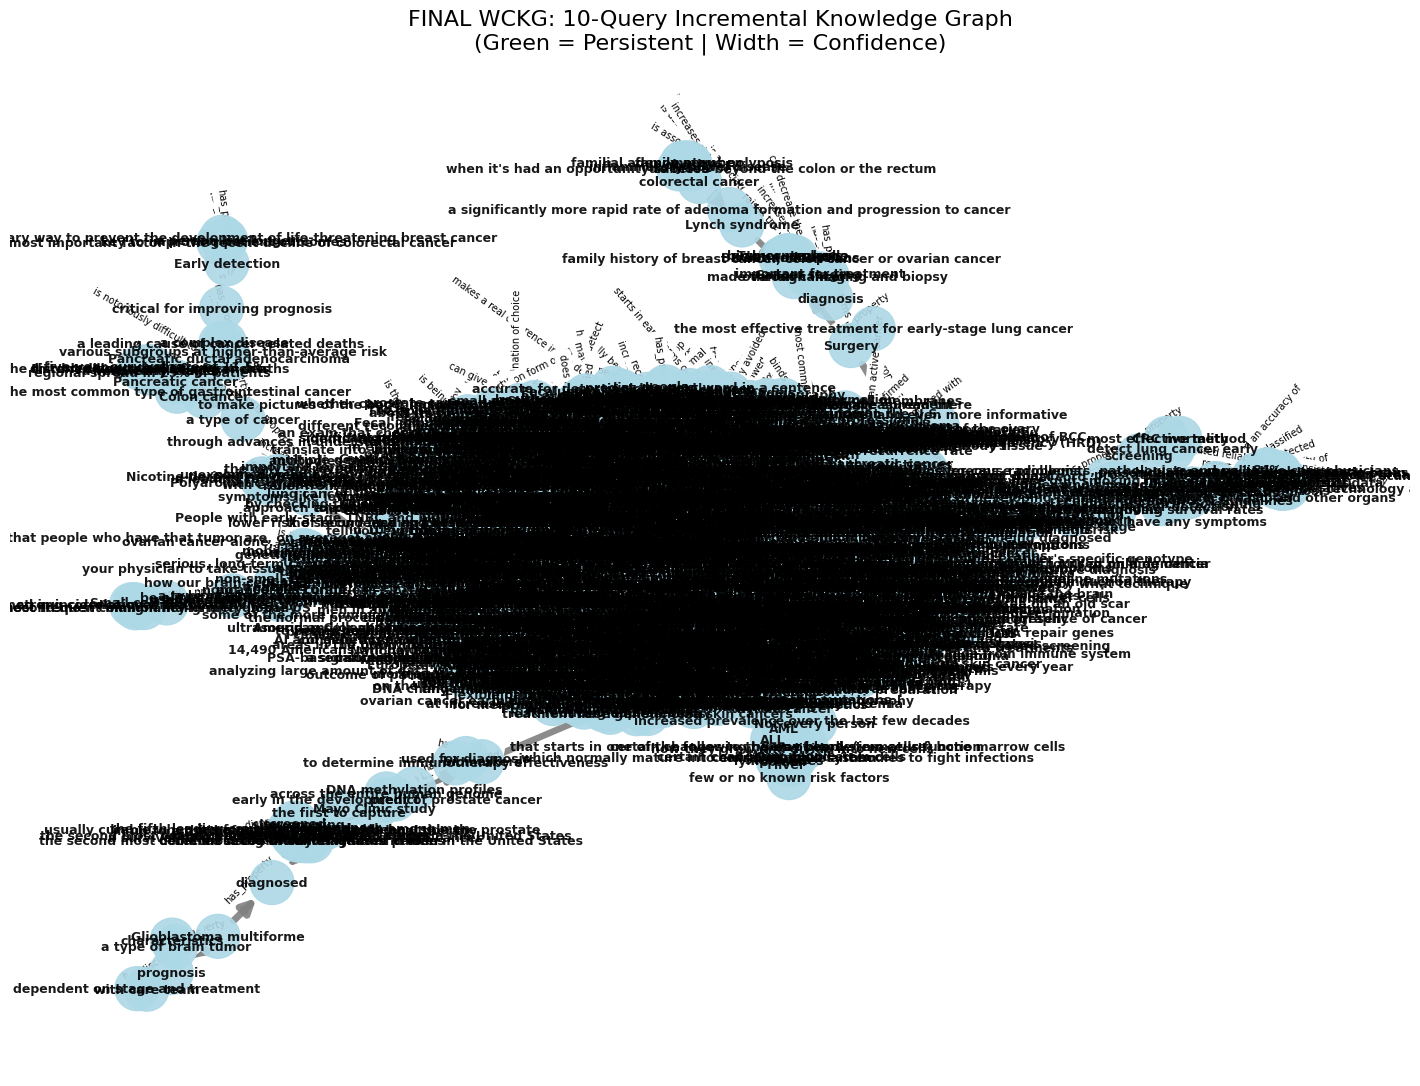

In [7]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os

RESULTS_FILE = Path("triple_extraction_results.pkl")
if not RESULTS_FILE.exists():
    raise FileNotFoundError("Run triple extraction first! Missing: triple_extraction_results.pkl")

with open(RESULTS_FILE, "rb") as f:
    all_extracted = pickle.load(f)

print(f"Loaded {len(all_extracted)} pages with triples")

cancer_queries = [
    "types of lung cancer and their characteristics",
    "breast cancer diagnosis accuracy with AI",
    "colorectal cancer screening methods",
    "prostate cancer biomarkers",
    "pancreatic cancer early detection challenges",
    "skin cancer melanoma vs basal cell",
    "ovarian cancer symptoms and diagnosis",
    "leukemia types and treatment",
    "brain cancer glioblastoma prognosis",
    "thyroid cancer risk factors"
]

query_triples = {q: [] for q in cancer_queries}
for page in all_extracted:
    q = page["query"]
    if q in query_triples:
        query_triples[q].extend(page["triples"])

print("\nTriples per query:")
for q in cancer_queries:
    count = len(query_triples[q])
    print(f"  • {q[:60]:60} → {count} triples")

def build_local_kg(
    triples: list,
    threshold: float = 0.75
) -> nx.DiGraph:
    G = nx.DiGraph()
    seen = set()

    for s, p, o, conf, url, ts, pers in triples:
        if conf < threshold:
            continue
        key = (s, p, o)
        if key in seen:
            continue
        seen.add(key)

        G.add_node(s, type="concept", persistence=pers)
        G.add_node(o, type="concept", persistence=pers)
        G.add_edge(
            s, o,
            predicate=p,
            confidence=conf,
            url=url,
            timestamp=ts,
            persistent=pers,
            source_doc=url.split("/")[-1][:40]
        )
    return G

def merge_kg(global_g: nx.DiGraph, local_g: nx.DiGraph) -> nx.DiGraph:
    merged = global_g.copy()
    for u, v, data in local_g.edges(data=True):
        pred = data['predicate']
        conf = data['confidence']
        url = data['url']
        ts = data['timestamp']
        pers = data['persistent']

        if merged.has_edge(u, v) and merged[u][v].get('predicate') == pred:
            curr = merged[u][v]
            old_conf = curr.get('confidence', 0.0)
            curr['confidence'] = (old_conf + conf) / 2
            curr['url'] = f"{curr.get('url','')}; {url}".strip("; ")
            curr['persistent'] = curr.get('persistent', False) or pers
        else:
            merged.add_edge(u, v, **data)

    for node in merged.nodes:
        inc = [d.get('persistent', False) for _, _, d in merged.in_edges(node, data=True)]
        out = [d.get('persistent', False) for _, _, d in merged.out_edges(node, data=True)]
        merged.nodes[node]['persistence'] = any(inc + out)
    return merged

global_kg = nx.DiGraph()
step_stats = []

print("\n" + "="*80)
print("BUILDING 10 INCREMENTAL KGs")
print("="*80)

for step, query in enumerate(cancer_queries, 1):
    print(f"\nSTEP {step:02d}: {query[:60]}")
    
    local_triples = query_triples[query]
    local_kg = build_local_kg(local_triples, threshold=0.75)
    print(f"  Local: {local_kg.number_of_nodes()} nodes, {local_kg.number_of_edges()} edges")

    global_kg = merge_kg(global_kg, local_kg)

    step_file = f"kg_step_{step:02d}.pkl"
    with open(step_file, "wb") as f:
        pickle.dump(global_kg, f)

    nodes = global_kg.number_of_nodes()
    edges = global_kg.number_of_edges()
    pers_nodes = sum(1 for n in global_kg.nodes if global_kg.nodes[n].get('persistence', False))
    pers_edges = sum(1 for _, _, d in global_kg.edges(data=True) if d.get('persistent', False))

    step_stats.append({
        "step": step,
        "query": query,
        "new_triples": len(local_triples),
        "total_nodes": nodes,
        "total_edges": edges,
        "persistent_nodes": pers_nodes,
        "persistent_edges": pers_edges,
        "kg_file": step_file
    })

    print(f"  GLOBAL: {nodes} nodes, {edges} edges | {pers_nodes} persistent nodes")

final_kg_file = "final_kg.pkl"
with open(final_kg_file, "wb") as f:
    pickle.dump(global_kg, f)

import json
with open("kg_build_stats.json", "w") as f:
    json.dump(step_stats, f, indent=2)

final = step_stats[-1]
print("\n" + "="*80)
print("INCREMENTAL WCKG BUILD COMPLETE!")
print(f"Final KG: {final['total_nodes']} nodes, {final['total_edges']} edges")
print(f"Persistent: {final['persistent_nodes']} nodes, {final['persistent_edges']} edges")
print(f"Saved: kg_step_01.pkl → kg_step_10.pkl")
print(f"Final KG: {final_kg_file}")
print(f"Stats: kg_build_stats.json")
print("="*80)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(global_kg, k=1.5, iterations=80, seed=42)

node_colors = ['#90EE90' if global_kg.nodes[n].get('persistence', False) else '#ADD8E6' for n in global_kg.nodes]
edge_widths = [global_kg[u][v].get('confidence', 0.5) * 5 for u, v in global_kg.edges]

nx.draw(
    global_kg, pos,
    with_labels=True,
    node_size=1000,
    node_color=node_colors,
    font_size=9,
    font_weight="bold",
    edge_color="gray",
    width=edge_widths,
    arrowsize=20,
    alpha=0.9
)

edge_labels = {}
for u, v in global_kg.edges:
    data = global_kg[u][v]
    label = data['predicate']
    if data.get('persistent'):
        label += " [P]"
    edge_labels[(u, v)] = label

nx.draw_networkx_edge_labels(
    global_kg, pos,
    edge_labels=edge_labels,
    font_size=7,
    label_pos=0.6,
    verticalalignment='bottom'
)

plt.title("FINAL WCKG: 10-Query Incremental Knowledge Graph\n(Green = Persistent | Width = Confidence)", 
          fontsize=16, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
import faiss
import numpy as np
import pickle
import networkx as nx
from pathlib import Path
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import os

embedder = SentenceTransformer('all-MiniLM-L6-v2')
DIM = 384

def embed_nodes_rich(kg: nx.DiGraph) -> tuple:
    node_texts = []
    for node in kg.nodes():
        parts = [node]
        # Outgoing
        for _, obj, data in kg.out_edges(node, data=True):
            pred = data.get('predicate', '')
            conf = data.get('confidence', 0.5)
            weight = f"({conf:.2f})" if conf >= 0.7 else ""
            parts.append(f"{pred} {obj}{weight}")
        # Incoming
        for subj, _, data in kg.in_edges(node, data=True):
            pred = data.get('predicate', '')
            parts.append(f"{subj} {pred}")
        # Persistence
        if kg.nodes[node].get('persistence', False):
            parts.append("[PERSISTENT]")
        node_texts.append(" | ".join(parts))
    embeddings = embedder.encode(node_texts).astype('float32')
    return embeddings, node_texts

def build_faiss_index(kg: nx.DiGraph, step: int | str):
    if kg.number_of_nodes() == 0:
        return None, None, None, None

    print(f"  → Embedding {kg.number_of_nodes()} nodes...")
    embeddings, node_texts = embed_nodes_rich(kg)

    print(f"  → Building FAISS index...")
    index = faiss.IndexFlatL2(DIM)
    index.add(embeddings)

    nodes = list(kg.nodes())

    # ---- FILE NAME (int → 01,02,… ; str "final" → final) ----
    if isinstance(step, int):
        index_file = f"faiss_index_step_{step:02d}.pkl"
    else:   # e.g. "final"
        index_file = f"faiss_index_{step}.pkl"

    # ---- SAVE ----
    with open(index_file, "wb") as f:
        pickle.dump({
            "index": index,
            "embeddings": embeddings,
            "nodes": nodes,
            "node_texts": node_texts,
            "kg_nodes": kg.number_of_nodes(),
            "kg_edges": kg.number_of_edges()
        }, f)

    return index, embeddings, nodes, node_texts

print("="*80)
print("SETTING UP FAISS INDEX FOR ALL 10 INCREMENTAL KGs")
print("="*80)

faiss_data = {}

for step in tqdm(range(1, 11), desc="FAISS Indexing"):
    kg_file = f"kg_step_{step:02d}.pkl"
    if not Path(kg_file).exists():
        print(f"  [SKIP] {kg_file} not found")
        continue

    with open(kg_file, "rb") as f:
        kg = pickle.load(f)

    print(f"\nSTEP {step:02d}: {kg.number_of_nodes()} nodes, {kg.number_of_edges()} edges")
    idx, emb, nds, txt = build_faiss_index(kg, step)

    faiss_data[step] = {
        "index": idx,
        "embeddings": emb,
        "nodes": nds,
        "node_texts": txt,
        "kg_file": kg_file
    }

final_kg_file = "final_kg.pkl"
if Path(final_kg_file).exists():
    print(f"\nIndexing FINAL KG...")
    with open(final_kg_file, "rb") as f:
        final_kg = pickle.load(f)

    idx, emb, nds, txt = build_faiss_index(final_kg, "final")
    faiss_data["final"] = {
        "index": idx,
        "embeddings": emb,
        "nodes": nds,
        "node_texts": txt,
        "kg_file": final_kg_file
    }

with open("faiss_master_index.pkl", "wb") as f:
    pickle.dump(faiss_data, f)

print("\n" + "="*80)
print("FAISS SETUP COMPLETE!")
print("Indexed 10 steps + final KG")
print("Files saved:")
print("  • faiss_index_step_01.pkl → faiss_index_step_10.pkl")
print("  • faiss_index_final.pkl")
print("  • faiss_master_index.pkl")
print("="*80)

print("\nQuick test: retrieving from FINAL KG...")
test_query = "How does AI improve cancer diagnosis accuracy?"
final_data = faiss_data.get("final")
if final_data:
    q_emb = embedder.encode([test_query]).astype('float32')
    D, I = final_data["index"].search(q_emb, 3)
    print("Top 3 nodes:")
    for d, i in zip(D[0], I[0]):
        node = final_data["nodes"][i]
        print(f"  • {node} (sim={1/(1+d):.3f})")

SETTING UP FAISS INDEX FOR ALL 10 INCREMENTAL KGs


FAISS Indexing:   0%|                                                                           | 0/10 [00:00<?, ?it/s]


STEP 01: 156 nodes, 99 edges
  → Embedding 156 nodes...


FAISS Indexing:  10%|██████▋                                                            | 1/10 [00:01<00:12,  1.40s/it]

  → Building FAISS index...

STEP 02: 300 nodes, 191 edges
  → Embedding 300 nodes...


FAISS Indexing:  20%|█████████████▍                                                     | 2/10 [00:03<00:15,  1.99s/it]

  → Building FAISS index...

STEP 03: 435 nodes, 290 edges
  → Embedding 435 nodes...


FAISS Indexing:  30%|████████████████████                                               | 3/10 [00:07<00:18,  2.69s/it]

  → Building FAISS index...

STEP 04: 592 nodes, 416 edges
  → Embedding 592 nodes...


FAISS Indexing:  40%|██████████████████████████▊                                        | 4/10 [00:13<00:23,  4.00s/it]

  → Building FAISS index...

STEP 05: 694 nodes, 500 edges
  → Embedding 694 nodes...


FAISS Indexing:  50%|█████████████████████████████████▌                                 | 5/10 [00:19<00:24,  4.94s/it]

  → Building FAISS index...

STEP 06: 797 nodes, 580 edges
  → Embedding 797 nodes...


FAISS Indexing:  60%|████████████████████████████████████████▏                          | 6/10 [00:27<00:23,  5.76s/it]

  → Building FAISS index...

STEP 07: 990 nodes, 727 edges
  → Embedding 990 nodes...


FAISS Indexing:  70%|██████████████████████████████████████████████▉                    | 7/10 [00:35<00:19,  6.65s/it]

  → Building FAISS index...

STEP 08: 1092 nodes, 807 edges
  → Embedding 1092 nodes...


FAISS Indexing:  80%|█████████████████████████████████████████████████████▌             | 8/10 [00:45<00:14,  7.48s/it]

  → Building FAISS index...

STEP 09: 1213 nodes, 910 edges
  → Embedding 1213 nodes...


FAISS Indexing:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [00:55<00:08,  8.26s/it]

  → Building FAISS index...

STEP 10: 1295 nodes, 969 edges
  → Embedding 1295 nodes...


FAISS Indexing: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.57s/it]

  → Building FAISS index...

Indexing FINAL KG...
  → Embedding 1295 nodes...


  → Building FAISS index...

FAISS SETUP COMPLETE!
Indexed 10 steps + final KG
Files saved:
  • faiss_index_step_01.pkl → faiss_index_step_10.pkl
  • faiss_index_final.pkl
  • faiss_master_index.pkl

Quick test: retrieving from FINAL KG...
Top 3 nodes:
  • cancer with high accuracy (sim=0.731)
  • accuracy of lung cancer diagnosis (sim=0.705)
  • accuracy of diagnosis (sim=0.698)


In [14]:
import pickle
import json
from tqdm import tqdm
from urllib.parse import urlparse
import time
import random

def baseline_rag_response(
    query: str,
    top_k: int = 4,
    max_chars_per_doc: int = 2500
):
    print(f"[RAG] Query: {query[:60]}...")
    sources = []
    source_metadata = []

    search_results = None
    for attempt in range(3):
        try:
            search_results = web_search(query, num_results=top_k)
            if search_results:
                break
        except Exception as e:
            print(f"  [RAG] Web search failed (attempt {attempt+1}): {e}")
            time.sleep(2)
    
    if not search_results:
        print("  [RAG] Falling back to scraped_content.pkl...")
        try:
            with open("scraped_content.pkl", "rb") as f:
                scraped = pickle.load(f)
            matching = [p for p in scraped.values() if query.lower() in p.get("query", "").lower()]
            search_results = [
                {"url": p["url"], "title": p.get("title", "Scraped"), "date": "2025"}
                for p in random.sample(matching, min(top_k, len(matching)))
            ]
        except:
            search_results = []

    if not search_results:
        return "No sources available (web + cache failed).", []

    contexts = []
    for res in search_results:
        url = res["url"]
        meta = {
            "url": url,
            "title": res.get("title", "No title"),
            "date": res.get("date", "unknown"),
            "domain": urlparse(url).netloc
        }

        try:
            keywords = list(set(query.lower().split()[:6] + domain_topic.lower().split()))
            text = scrape_content(url, topic_keywords=keywords)
            if len(text) > 150:
                contexts.append(text[:max_chars_per_doc])
                sources.append(text)
                source_metadata.append(meta)
        except:
            continue

    if not contexts:
        return "No valid content retrieved.", []

    context_str = ""
    for i, (ctx, meta) in enumerate(zip(contexts, source_metadata)):
        context_str += f"\nSource {i+1} ({meta['domain']}, {meta['date']}):\n{ctx}\n---\n"

    rag_prompt = f"""
You are a medical AI expert. Answer using ONLY the provided sources.
Cite sources using [Source N] notation.
Sources:
{context_str}
Question: {query}
Requirements:
1. Use ONLY information from provided sources
2. Cite sources for every claim [Source N]
3. If uncertain, say: "Not stated in sources"
4. Be precise
Answer:
"""

    try:
        resp = client.chat.completions.create(  # FIXED
            model="meta-llama/llama-3-8b-instruct",
            messages=[{"role": "user", "content": rag_prompt}],
            temperature=0.5,
            max_tokens=600
        )
        return resp.choices[0].message.content.strip(), sources
    except Exception as e:
        return f"RAG LLM Error: {str(e)}", []

cancer_queries = [
    "types of lung cancer and their characteristics",
    "breast cancer diagnosis accuracy with AI",
    "colorectal cancer screening methods",
    "prostate cancer biomarkers",
    "pancreatic cancer early detection challenges",
    "skin cancer melanoma vs basal cell",
    "ovarian cancer symptoms and diagnosis",
    "leukemia types and treatment",
    "brain cancer glioblastoma prognosis",
    "thyroid cancer risk factors"
]

final_test_query = "How does AI improve cancer diagnosis accuracy across different cancer types?"
all_queries = cancer_queries + [final_test_query]

print("\n" + "="*80)
print("GENERATING ROBUST RAG ANSWERS (WITH FALLBACK)")
print("="*80)

rag_answers = {}

for i, query in enumerate(tqdm(all_queries, desc="RAG Answers")):
    query_key = f"QUERY_{i+1:0202d}" if i < 10 else "FINAL_TEST"
    answer, sources = baseline_rag_response(query, top_k=4)
    rag_answers[query_key] = {
        "query": query,
        "answer": answer,
        "sources": sources,
        "source_count": len(sources),
        "status": "success" if "Error" not in answer and "No sources" not in answer else "failed"
    }

RAG_FILE = "rag_answers.pkl"
with open(RAG_FILE, "wb") as f:
    pickle.dump(rag_answers, f)

with open("rag_answers_readable.json", "w", encoding="utf-8") as f:
    json.dump(rag_answers, f, indent=2, ensure_ascii=False)

success = sum(1 for v in rag_answers.values() if v["status"] == "success")
print("\n" + "="*80)
print("ROBUST RAG COMPLETE!")
print(f"Success: {success}/11 | Failed: {11-success}/11")
print(f"Saved: {RAG_FILE}")
print(f"Readable: rag_answers_readable.json")
print("="*80)

example = rag_answers["QUERY_01"]
print(f"\nExample RAG Answer (first 300 chars):\n{example['answer'][:300]}...")


GENERATING ROBUST RAG ANSWERS (WITH FALLBACK)


RAG Answers:   0%|                                                                              | 0/11 [00:00<?, ?it/s]

[RAG] Query: types of lung cancer and their characteristics...
Selenium success (attempt 1): https://www.hopkinsmedicine.org/health/conditions-...
Selenium success (attempt 1): https://my.clevelandclinic.org/health/diseases/437...
Selenium success (attempt 1): https://www.lung.org/lung-health-diseases/lung-dis...
Selenium success (attempt 1): https://www.cancer.org/cancer/types/lung-cancer/ab...


RAG Answers:   9%|██████▎                                                              | 1/11 [03:37<36:14, 217.43s/it]

[RAG] Query: breast cancer diagnosis accuracy with AI...
Selenium success (attempt 1): https://www.nature.com/articles/s41591-024-03408-6...
Selenium success (attempt 1): https://www.breastcancer.org/screening-testing/art...
Selenium success (attempt 1): https://www.uclahealth.org/news/release/ai-could-h...
Selenium success (attempt 1): https://pmc.ncbi.nlm.nih.gov/articles/PMC10625863/...


RAG Answers:  18%|████████████▌                                                        | 2/11 [07:29<33:54, 226.04s/it]

[RAG] Query: colorectal cancer screening methods...
Selenium success (attempt 1): https://www.cancer.org/cancer/types/colon-rectal-c...
Selenium success (attempt 1): https://www.cdc.gov/colorectal-cancer/screening/in...
Selenium success (attempt 1): https://www.cancer.gov/types/colorectal/screening-...
Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/col...


RAG Answers:  27%|██████████████████▊                                                  | 3/11 [10:47<28:26, 213.27s/it]

[RAG] Query: prostate cancer biomarkers...
Saved: 4 results | prostate cancer biomarkers...
Selenium success (attempt 1): https://pmc.ncbi.nlm.nih.gov/articles/PMC9201356/...
Selenium success (attempt 1): https://icurology.org/DOIx.php?id=10.4111/icu.2024...
Selenium success (attempt 1): https://www.mdpi.com/2075-4418/13/21/3350...
Selenium success (attempt 1): https://cancer.pfizer.com/prostate-cancer/biomarke...


RAG Answers:  36%|█████████████████████████                                            | 4/11 [13:59<23:53, 204.72s/it]

[RAG] Query: pancreatic cancer early detection challenges...
Saved: 4 results | pancreatic cancer early detection challenges...
Selenium success (attempt 1): https://pmc.ncbi.nlm.nih.gov/articles/PMC6486851/...
Selenium success (attempt 1): https://www.jci.org/articles/view/191942...
Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 16.840
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x904093
	0x9040d4
	0x70e71d
	0x6fec5a
	0x6fe98d
	0x6fc7fe
	0x6fd3c7
	0x70a16e
	0x71c095
	0x721be6
	0x6fda46
	0x71be27
	0x79f14f
	0x77c706
	0x74da30
	0x74ed54
	0xb75744
	0xb7091a
	0x92c322
	0x91c458
	0x9231dd
	0x90c408
	0x90c5cc
	0x8f675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium failed (attempt 2): Message: timeout: Timed out receiving message from renderer: 18.789
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0xc14093
	0xc140d4
	0xa1e71d
	0xa

RAG Answers:  45%|███████████████████████████████▎                                     | 5/11 [21:17<28:52, 288.82s/it]

[RAG] Query: skin cancer melanoma vs basal cell...
Saved: 4 results | skin cancer melanoma vs basal cell...
Selenium success (attempt 1): https://dermatologyseattle.com/basal-cell-carcinom...
Selenium success (attempt 1): https://www.healthline.com/health/skin-cancer/basa...
Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 18.111
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0xdd4093
	0xdd40d4
	0xbde71d
	0xbcec5a
	0xbce98d
	0xbcc7fe
	0xbcd3c7
	0xbda16e
	0xbec095
	0xbf1be6
	0xbcda46
	0xbebe27
	0xc6f14f
	0xc4c706
	0xc1da30
	0xc1ed54
	0x1045744
	0x104091a
	0xdfc322
	0xdec458
	0xdf31dd
	0xddc408
	0xddc5cc
	0xdc675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium success (attempt 2): https://www.mdanderson.org/cancerwise/types-of-ski...
Selenium success (attempt 1): https://www.mohssurgery.org/blog/skin-cancer/ident...


RAG Answers:  55%|█████████████████████████████████████▋                               | 6/11 [28:31<28:11, 338.37s/it]

[RAG] Query: ovarian cancer symptoms and diagnosis...
Saved: 4 results | ovarian cancer symptoms and diagnosis...
Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/ova...
Selenium success (attempt 1): https://my.clevelandclinic.org/health/diseases/444...
Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 17.106
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x1014093
	0x10140d4
	0xe1e71d
	0xe0ec5a
	0xe0e98d
	0xe0c7fe
	0xe0d3c7
	0xe1a16e
	0xe2c095
	0xe31be6
	0xe0da46
	0xe2be27
	0xeaf14f
	0xe8c706
	0xe5da30
	0xe5ed54
	0x1285744
	0x128091a
	0x103c322
	0x102c458
	0x10331dd
	0x101c408
	0x101c5cc
	0x100675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium success (attempt 2): https://www.cancer.org/cancer/types/ovarian-cancer...
Selenium success (attempt 1): https://www.unitypoint.org/news-and-articles/dont-...


RAG Answers:  64%|███████████████████████████████████████████▉                         | 7/11 [32:59<21:01, 315.36s/it]

[RAG] Query: leukemia types and treatment...
Saved: 4 results | leukemia types and treatment...
Selenium failed (attempt 1): Message: timeout: Timed out receiving message from renderer: 19.291
  (Session info: chrome=142.0.7444.162)
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x1104093
	0x11040d4
	0xf0e71d
	0xefec5a
	0xefe98d
	0xefc7fe
	0xefd3c7
	0xf0a16e
	0xf1c095
	0xf21be6
	0xefda46
	0xf1be27
	0xf9f14f
	0xf7c706
	0xf4da30
	0xf4ed54
	0x1375744
	0x137091a
	0x112c322
	0x111c458
	0x11231dd
	0x110c408
	0x110c5cc
	0x10f675a
	0x76375d49
	0x77a6d6db
	0x77a6d661

Selenium success (attempt 2): https://my.clevelandclinic.org/health/diseases/436...
Selenium success (attempt 1): https://hillman.upmc.com/cancer-care/blood/types/l...
Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/leu...
Selenium success (attempt 1): https://www.ncbi.nlm.nih.gov/books/NBK560490/...
LLM filter error: Connection error.


RAG Answers:  73%|██████████████████████████████████████████████████▏                  | 8/11 [37:10<14:43, 294.66s/it]

[RAG] Query: brain cancer glioblastoma prognosis...
Saved: 4 results | brain cancer glioblastoma prognosis...
Selenium success (attempt 1): https://glioblastomafoundation.org/news/what-is-th...
Selenium success (attempt 1): https://my.clevelandclinic.org/health/diseases/170...
Selenium success (attempt 1): https://www.thebraintumourcharity.org/brain-tumour...
Selenium success (attempt 1): https://www.ivybraintumorcenter.org/brain-tumor-ca...


RAG Answers:  82%|████████████████████████████████████████████████████████▍            | 9/11 [41:12<09:16, 278.27s/it]

[RAG] Query: thyroid cancer risk factors...
Saved: 4 results | thyroid cancer risk factors...
Selenium success (attempt 1): https://www.cancer.org/cancer/types/thyroid-cancer...
Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/thy...
Selenium success (attempt 1): https://www.cancerresearchuk.org/about-cancer/thyr...
Selenium success (attempt 1): https://pubmed.ncbi.nlm.nih.gov/18406782/...


RAG Answers:  91%|█████████████████████████████████████████████████████████████▊      | 10/11 [44:44<04:17, 257.93s/it]

[RAG] Query: How does AI improve cancer diagnosis accuracy across differe...
Saved: 4 results | How does AI improve cancer diagnosis accuracy across differe...
Selenium success (attempt 1): https://www.cancer.gov/research/infrastructure/art...
Selenium success (attempt 1): https://hms.harvard.edu/news/new-artificial-intell...
Selenium success (attempt 1): https://pmc.ncbi.nlm.nih.gov/articles/PMC12427515/...
Selenium success (attempt 1): https://www.ccmedicalcenter.com/healthy-living/blo...


RAG Answers: 100%|████████████████████████████████████████████████████████████████████| 11/11 [48:52<00:00, 266.55s/it]


ROBUST RAG COMPLETE!
Success: 10/11 | Failed: 1/11
Saved: rag_answers.pkl
Readable: rag_answers_readable.json


KeyError: 'QUERY_01'

In [16]:
query = "leukemia types and treatment"
answer, sources = baseline_rag_response(query, top_k=4)

[RAG] Query: leukemia types and treatment...
Selenium success (attempt 1): https://my.clevelandclinic.org/health/diseases/436...
Selenium success (attempt 1): https://hillman.upmc.com/cancer-care/blood/types/l...
Selenium success (attempt 1): https://www.mayoclinic.org/diseases-conditions/leu...
Selenium success (attempt 1): https://www.ncbi.nlm.nih.gov/books/NBK560490/...


In [10]:
# =====================================
# CELL 8: WCKG ANSWERS FOR ALL 10 QUERIES + FINAL TEST QUERY
# =====================================
import pickle
from pathlib import Path
import json
from tqdm import tqdm

# ------------------------------------------------------------------
# 1. LOAD FAISS MASTER INDEX
# ------------------------------------------------------------------
MASTER_FILE = Path("faiss_master_index.pkl")
if not MASTER_FILE.exists():
    raise FileNotFoundError("Run CELL 7 first! Missing: faiss_master_index.pkl")

with open(MASTER_FILE, "rb") as f:
    faiss_data = pickle.load(f)

print(f"Loaded FAISS indices: {list(faiss_data.keys())}")

# ------------------------------------------------------------------
# 2. DEFINE 10 CANCER QUERIES + FINAL TEST QUERY
# ------------------------------------------------------------------
cancer_queries = [
    "types of lung cancer and their characteristics",
    "breast cancer diagnosis accuracy with AI",
    "colorectal cancer screening methods",
    "prostate cancer biomarkers",
    "pancreatic cancer early detection challenges",
    "skin cancer melanoma vs basal cell",
    "ovarian cancer symptoms and diagnosis",
    "leukemia types and treatment",
    "brain cancer glioblastoma prognosis",
    "thyroid cancer risk factors"
]

final_test_query = "How does AI improve cancer diagnosis accuracy across different cancer types?"

# ------------------------------------------------------------------
# 3. RETRIEVE SIMILAR NODES (from CELL 7)
# ------------------------------------------------------------------
def retrieve_similar_nodes(
    query: str,
    index, nodes, node_texts,
    k: int = 6
) -> list:
    if index is None:
        return []
    q_emb = embedder.encode([query]).astype('float32')
    D, I = index.search(q_emb, k)
    results = []
    for dist, idx in zip(D[0], I[0]):
        if idx >= len(nodes):
            continue
        node = nodes[idx]
        score = 1 / (1 + dist)
        results.append({
            'node': node,
            'similarity': round(score, 3)
        })
    return results

# ------------------------------------------------------------------
# 4. WCKG RESPONSE (from your old code – slightly cleaned)
# ------------------------------------------------------------------
def wckg_response(
    query: str,
    index, nodes, node_texts,
    kg: nx.DiGraph,
    k: int = 6,
    min_confidence: float = 0.75
) -> str:
    print(f"[WCKG] Query: {query[:60]}...")
    retrieved = retrieve_similar_nodes(query, index, nodes, node_texts, k=k)
    if not retrieved:
        return "No relevant KG facts found."

    kg_facts = []
    seen_edges = set()
    for item in retrieved:
        node = item['node']
        # Outgoing
        for _, obj, data in kg.out_edges(node, data=True):
            if data.get('confidence', 0) < min_confidence: continue
            key = (node, data['predicate'], obj)
            if key in seen_edges: continue
            seen_edges.add(key)
            kg_facts.append({**data, 's': node, 'o': obj})
        # Incoming
        for subj, _, data in kg.in_edges(node, data=True):
            if data.get('confidence', 0) < min_confidence: continue
            key = (subj, data['predicate'], node)
            if key in seen_edges: continue
            seen_edges.add(key)
            kg_facts.append({**data, 's': subj, 'o': node})

    kg_facts.sort(key=lambda x: x['confidence'], reverse=True)
    kg_facts = kg_facts[:10]

    context_lines = []
    source_map = {}
    next_id = 1
    for f in kg_facts:
        url = f['url']
        if url not in source_map:
            source_map[url] = f"Source {next_id}"
            next_id += 1
        src_label = source_map[url]
        date = f['timestamp'][:10] if len(f['timestamp']) > 10 else "unknown"
        pers_tag = " [PERSISTENT]" if f.get('persistent', False) else ""
        line = f"[{src_label}] {f['s']} {f['predicate']} {f['o']} (conf={f['confidence']:.2f}, {date}){pers_tag}"
        context_lines.append(line)

    context = "\n".join(context_lines)
    prompt = f"""
You are a medical AI expert. Answer **only** using the facts below.
- Cite every claim with [Source N]
- Include confidence score
- Mark persistent facts with [P]
- If no fact supports a claim, say: "No KG evidence"
Knowledge Graph Facts:
{context}
Question: {query}
Answer (strictly grounded):
"""

    try:
        resp = client.chat.completions.create(
            model="meta-llama/llama-3-8b-instruct",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=500
        )
        answer = resp.choices[0].message.content.strip()
        source_defs = "\n\nSources:\n"
        for url, label in source_map.items():
            domain = url.split('/')[2] if '/' in url else url
            source_defs += f"{label}: {domain} ({url[:60]}...)\n"
        final_answer = answer + source_defs
        print(f"[WCKG] Done → {len(answer.split())} words")
        return final_answer
    except Exception as e:
        return f"WCKG Error: {str(e)}"

# ------------------------------------------------------------------
# 5. RUN WCKG ON ALL 11 QUERIES
# ------------------------------------------------------------------
print("\n" + "="*80)
print("GENERATING WCKG ANSWERS FOR 11 QUERIES")
print("="*80)

answers = {}

# --- 10 incremental queries ---
for step in tqdm(range(1, 11), desc="WCKG Answers (Steps)"):
    query = cancer_queries[step - 1]
    step_key = step
    if step_key not in faiss_data:
        answers[query] = "FAISS index missing for this step."
        continue

    data = faiss_data[step_key]
    kg_file = data["kg_file"]
    with open(kg_file, "rb") as f:
        kg = pickle.load(f)

    answer = wckg_response(
        query=query,
        index=data["index"],
        nodes=data["nodes"],
        node_texts=data["node_texts"],
        kg=kg,
        k=6,
        min_confidence=0.75
    )
    answers[query] = answer

# --- Final test query (on FINAL KG) ---
print(f"\nFinal Test Query (on final KG): {final_test_query[:60]}...")
final_data = faiss_data.get("final")
if final_data:
    with open(final_data["kg_file"], "rb") as f:
        final_kg = pickle.load(f)
    final_answer = wckg_response(
        query=final_test_query,
        index=final_data["index"],
        nodes=final_data["nodes"],
        node_texts=final_data["node_texts"],
        kg=final_kg,
        k=6,
        min_confidence=0.75
    )
    answers["FINAL_TEST"] = final_answer
else:
    answers["FINAL_TEST"] = "Final KG index not found."

# ------------------------------------------------------------------
# 6. SAVE ALL ANSWERS
# ------------------------------------------------------------------
ANSWERS_FILE = "wckg_answers.pkl"
with open(ANSWERS_FILE, "wb") as f:
    pickle.dump(answers, f)

# Save human-readable version
with open("wckg_answers_readable.json", "w", encoding="utf-8") as f:
    json.dump(answers, f, indent=2, ensure_ascii=False)

# ------------------------------------------------------------------
# 7. SUMMARY
# ------------------------------------------------------------------
print("\n" + "="*80)
print("WCKG ANSWERS COMPLETE!")
print(f"Total answers: {len(answers)}")
print(f"Saved: {ANSWERS_FILE}")
print(f"Readable: wckg_answers_readable.json")
print("="*80)

# Show one example
example_query = cancer_queries[0]
print(f"\nExample Answer (first 300 chars):\n{answers[example_query][:300]}...")

Loaded FAISS indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'final']

GENERATING WCKG ANSWERS FOR 11 QUERIES


WCKG Answers (Steps):   0%|                                                                     | 0/10 [00:00<?, ?it/s]

[WCKG] Query: types of lung cancer and their characteristics...


WCKG Answers (Steps):  10%|██████                                                       | 1/10 [00:07<01:11,  8.00s/it]

[WCKG] Done → 162 words
[WCKG] Query: breast cancer diagnosis accuracy with AI...


WCKG Answers (Steps):  20%|████████████▏                                                | 2/10 [00:13<00:51,  6.49s/it]

[WCKG] Done → 145 words
[WCKG] Query: colorectal cancer screening methods...


WCKG Answers (Steps):  30%|██████████████████▎                                          | 3/10 [00:18<00:41,  5.96s/it]

[WCKG] Done → 133 words
[WCKG] Query: prostate cancer biomarkers...


WCKG Answers (Steps):  40%|████████████████████████▍                                    | 4/10 [00:25<00:36,  6.07s/it]

[WCKG] Done → 151 words
[WCKG] Query: pancreatic cancer early detection challenges...


WCKG Answers (Steps):  50%|██████████████████████████████▌                              | 5/10 [00:26<00:22,  4.47s/it]

[WCKG] Done → 40 words
[WCKG] Query: skin cancer melanoma vs basal cell...


WCKG Answers (Steps):  60%|████████████████████████████████████▌                        | 6/10 [00:32<00:19,  4.83s/it]

[WCKG] Done → 227 words
[WCKG] Query: ovarian cancer symptoms and diagnosis...


WCKG Answers (Steps):  70%|██████████████████████████████████████████▋                  | 7/10 [00:39<00:16,  5.66s/it]

[WCKG] Done → 174 words
[WCKG] Query: leukemia types and treatment...


WCKG Answers (Steps):  80%|████████████████████████████████████████████████▊            | 8/10 [00:43<00:10,  5.10s/it]

[WCKG] Done → 124 words
[WCKG] Query: brain cancer glioblastoma prognosis...


WCKG Answers (Steps):  90%|██████████████████████████████████████████████████████▉      | 9/10 [00:48<00:05,  5.01s/it]

[WCKG] Done → 122 words
[WCKG] Query: thyroid cancer risk factors...


WCKG Answers (Steps): 100%|████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]

[WCKG] Done → 47 words

Final Test Query (on final KG): How does AI improve cancer diagnosis accuracy across differe...
[WCKG] Query: How does AI improve cancer diagnosis accuracy across differe...


[WCKG] Done → 168 words

WCKG ANSWERS COMPLETE!
Total answers: 11
Saved: wckg_answers.pkl
Readable: wckg_answers_readable.json

Example Answer (first 300 chars):
Based on the provided Knowledge Graph Facts, here is the answer:

**Types of Lung Cancer:**

1. **Non-Small Cell Lung Cancer (NSCLC)**: [Source 3] (conf=0.90, 2025-11-14) [P]
	* Note: No further information is available on the specific types of NSCLC.
2. **Other types of lung cancer**: [Source 4] (c...


Loading data...

HALLUCINATION SCORING: RAG vs WCKG (10 STEPS + FINAL)


Scoring Steps: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.72s/it]



Scoring FINAL TEST QUERY...


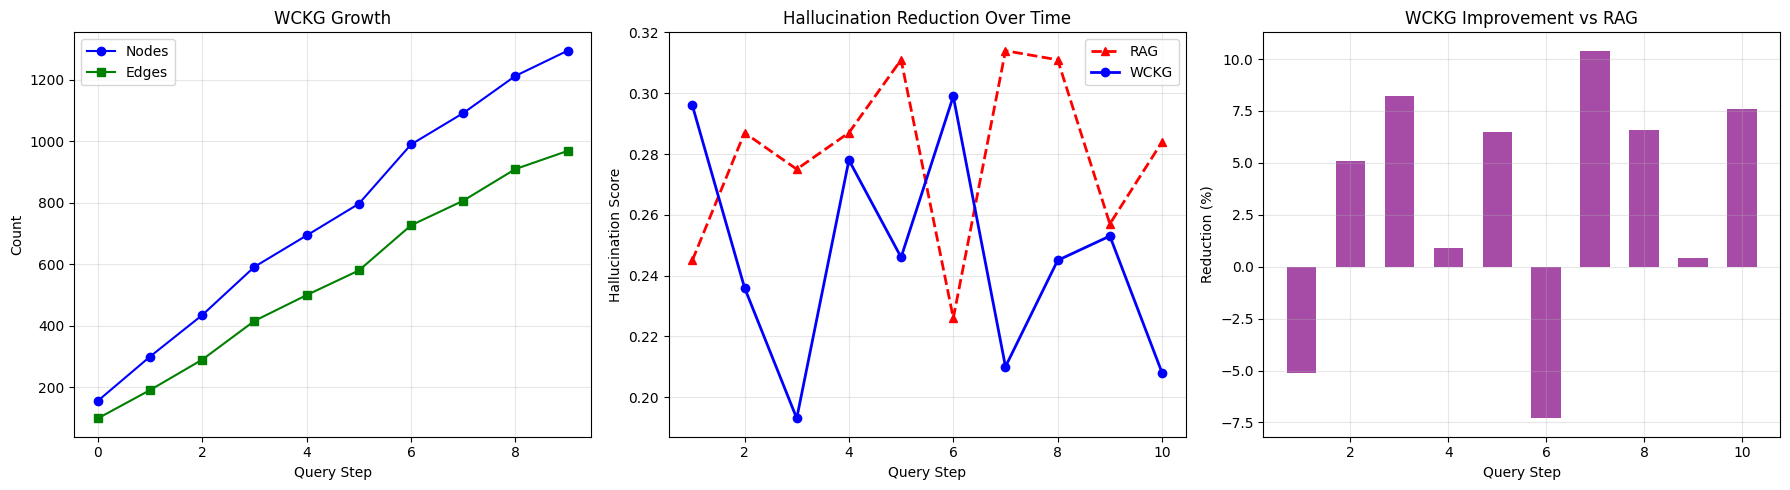


HALLUCINATION ANALYSIS COMPLETE!
Average Reduction (10 steps): 3.3%
Final Test Reduction: 5.1%
Final KG: 1295 nodes, 969 edges
Saved: hallucination_analysis.pkl, hallucination_analysis.json
Plot: hallucination_reduction_analysis.png


In [22]:
import pickle
import json
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import spacy

print("Loading data...")

with open("wckg_answers.pkl", "rb") as f:
    wckg_answers = pickle.load(f)

with open("rag_answers_readable.json", "r", encoding="utf-8") as f:
    rag_answers = json.load(f)

with open("faiss_master_index.pkl", "rb") as f:
    faiss_data = pickle.load(f)
with open("kg_build_stats.json", "r") as f:
    kg_stats = json.load(f)

embedder = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm")

def advanced_hallucination_scorer(
    query: str,
    answer: str,
    kg: nx.DiGraph = None,
    sources: list = None,
    index=None,
    nodes=None,
    node_texts=None
) -> dict:
    metrics = {}

    def source_grounding():
        if not sources and not kg:
            return 0.8
        answer_emb = embedder.encode([answer])[0]
        if sources:
            src_embs = embedder.encode(sources)
            sims = util.cos_sim(answer_emb, src_embs)[0]
            return 1 - float(sims.max())
        if kg:
            edge_texts = [f"{u} {d['predicate']} {v}" for u, v, d in kg.edges(data=True)]
            if not edge_texts:
                return 0.7
            edge_embs = embedder.encode(edge_texts)
            sims = util.cos_sim(answer_emb, edge_embs)[0]
            return 1 - float(sims.max())
        return 0.5
    metrics['source_grounding'] = source_grounding()

    def citation_accuracy():
        citations = re.findall(r'\[Source\s*\d+\]|\[\d+\]|Source\s+\d+', answer)
        if not citations:
            return 1.0
        if kg:
            source_defs = re.findall(r'Source \d+:[^\n]+', answer)
            return 0.1 if source_defs else 0.8
        return 0.2
    metrics['citation_accuracy'] = citation_accuracy()

    def semantic_consistency():
        prompt = f"Rate medical plausibility (0=contradictory, 100=perfect): {answer}\nOutput ONLY number."
        try:
            resp = client.chat.completions.create(
                model="meta-llama/llama-3-8b-instruct",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=5
            )
            score = float(resp.choices[0].message.content.strip())
            return max(0, min(100, score))
        except:
            return 80.0
    consistency = semantic_consistency()
    metrics['semantic_consistency'] = 1 - (consistency / 100)

    def entity_number_verification():
        doc = nlp(answer)
        claims = [ent.text for ent in doc.ents if ent.label_ in ("ORG", "PERSON", "GPE", "NORP", "DATE", "CARDINAL", "PERCENT", "MONEY", "QUANTITY")]
        numbers = re.findall(r'\d+(?:\.\d+)?%?', answer)
        claims.extend(numbers)
        if not claims:
            return 0.0
        if not kg:
            return 0.6
        kg_nodes = {n.lower() for n in kg.nodes()}
        kg_values = {str(d.get('confidence', '')).lower() for _, _, d in kg.edges(data=True)}
        verified = sum(1 for c in claims if any(c.lower() in node for node in kg_nodes) or c.lower() in kg_values)
        return 1 - (verified / len(claims))
    metrics['entity_number_verification'] = entity_number_verification()

    def persistence_confidence():
        if not kg:
            return 0.5
        persistent = [d for _, _, d in kg.edges(data=True) if d.get('persistent')]
        return 1 - np.mean([d['confidence'] for d in persistent]) if persistent else 0.6
    metrics['persistence_confidence'] = persistence_confidence()

    weights = {
        'source_grounding': 0.30,
        'citation_accuracy': 0.25,
        'semantic_consistency': 0.20,
        'entity_number_verification': 0.15,
        'persistence_confidence': 0.10
    }
    overall = sum(metrics[m] * weights[m] for m in weights)
    metrics['overall_hallucination'] = round(overall, 3)
    return metrics

print("\n" + "="*80)
print("HALLUCINATION SCORING: RAG vs WCKG (10 STEPS + FINAL)")
print("="*80)

results = []
cancer_queries = [f"QUERY_{i:02d}" for i in range(1, 11)]

for step in tqdm(range(1, 11), desc="Scoring Steps"):
    query_key = f"QUERY_{step:02d}"
    query = rag_answers[query_key]["query"]  # Get actual query text
    
    with open(f"kg_step_{step:02d}.pkl", "rb") as f:
        kg = pickle.load(f)
    
    wckg_ans = wckg_answers.get(query, "No answer")
    wckg_score = advanced_hallucination_scorer(
        query=query, answer=wckg_ans, kg=kg,
        index=faiss_data[step]["index"], nodes=faiss_data[step]["nodes"], node_texts=faiss_data[step]["node_texts"]
    )
    
    rag_data = rag_answers[query_key]
    rag_ans = rag_data["answer"]
    rag_sources = rag_data["sources"]
    rag_score = advanced_hallucination_scorer(
        query=query, answer=rag_ans, sources=rag_sources
    )
    
    results.append({
        "step": step,
        "query": query,
        "kg_nodes": kg.number_of_nodes(),
        "kg_edges": kg.number_of_edges(),
        "wckg_halluc": wckg_score['overall_hallucination'],
        "rag_halluc": rag_score['overall_hallucination'],
        "reduction": rag_score['overall_hallucination'] - wckg_score['overall_hallucination']
    })

print("\nScoring FINAL TEST QUERY...")
final_kg = pickle.load(open("final_kg.pkl", "rb"))
final_wckg = wckg_answers.get("FINAL_TEST", "No answer")
final_rag_data = rag_answers.get("FINAL_TEST", {})
final_rag_ans = final_rag_data.get("answer", "No answer")
final_rag_sources = final_rag_data.get("sources", [])

final_wckg_score = advanced_hallucination_scorer(
    query=final_test_query, answer=final_wckg, kg=final_kg,
    index=faiss_data["final"]["index"], nodes=faiss_data["final"]["nodes"], node_texts=faiss_data["final"]["node_texts"]
)
final_rag_score = advanced_hallucination_scorer(
    query=final_test_query, answer=final_rag_ans, sources=final_rag_sources
)

results.append({
    "step": "FINAL",
    "query": final_test_query,
    "kg_nodes": final_kg.number_of_nodes(),
    "kg_edges": final_kg.number_of_edges(),
    "wckg_halluc": final_wckg_score['overall_hallucination'],
    "rag_halluc": final_rag_score['overall_hallucination'],
    "reduction": final_rag_score['overall_hallucination'] - final_wckg_score['overall_hallucination']
})

with open("hallucination_analysis.pkl", "wb") as f:
    pickle.dump(results, f)
with open("hallucination_analysis.json", "w") as f:
    json.dump(results, f, indent=2)

steps = [r["step"] for r in results[:-1]]
final = results[-1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot([r["kg_nodes"] for r in results[:-1]], 'b-o', label='Nodes')
ax1.plot([r["kg_edges"] for r in results[:-1]], 'g-s', label='Edges')
ax1.set_xlabel("Query Step")
ax1.set_ylabel("Count")
ax1.set_title("WCKG Growth")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(steps, [r["rag_halluc"] for r in results[:-1]], 'r--^', label='RAG', linewidth=2)
ax2.plot(steps, [r["wckg_halluc"] for r in results[:-1]], 'b-o', label='WCKG', linewidth=2)
ax2.set_xlabel("Query Step")
ax2.set_ylabel("Hallucination Score")
ax2.set_title("Hallucination Reduction Over Time")
ax2.legend()
ax2.grid(True, alpha=0.3)

reductions = [r["reduction"] * 100 for r in results[:-1]]
ax3.bar(steps, reductions, color='purple', alpha=0.7, width=0.6)
ax3.set_xlabel("Query Step")
ax3.set_ylabel("Reduction (%)")
ax3.set_title("WCKG Improvement vs RAG")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("hallucination_reduction_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

avg_reduction = np.mean([r["reduction"] for r in results[:-1]]) * 100
final_reduction = final["reduction"] * 100

print("\n" + "="*80)
print("HALLUCINATION ANALYSIS COMPLETE!")
print(f"Average Reduction (10 steps): {avg_reduction:.1f}%")
print(f"Final Test Reduction: {final_reduction:.1f}%")
print(f"Final KG: {final['kg_nodes']} nodes, {final['kg_edges']} edges")
print(f"Saved: hallucination_analysis.pkl, hallucination_analysis.json")
print(f"Plot: hallucination_reduction_analysis.png")
print("="*80)

In [29]:
import pandas as pd
import json
import numpy as np
from IPython.display import display, HTML

with open("hallucination_analysis.json", "r") as f:
    results = json.load(f)

df = pd.DataFrame(results)

df = df.rename(columns={
    "step": "Step",
    "query": "Query",
    "kg_nodes": "Nodes",
    "kg_edges": "Edges",
    "wckg_halluc": "WCKG Halluc.",
    "rag_halluc": "RAG Halluc.",
    "reduction": "Reduction (%)"
})

df["Reduction (%)"] = (df["Reduction (%)"] * 100).round(2)

df["Step"] = df["Step"].replace("FINAL", "FINAL")

df = df[[
    "Step", "Query", "Nodes", "Edges",
    "RAG Halluc.", "WCKG Halluc.", "Reduction (%)"
]]

order = [f"{i}" for i in range(1, 11)] + ["FINAL"]
df["sort"] = df["Step"].map(lambda x: order.index(x) if x in order else 999)
df = df.sort_values("sort").drop("sort", axis=1).reset_index(drop=True)

def style_reduction(val):
    if val > 0:
        color = '#d4edda'  
        text = 'black'
    elif val < 0:
        color = '#f8d7da'  
        text = 'darkred'
    else:
        color = 'white'
        text = 'black'
    return f'background-color: {color}; color: {text}; font-weight: bold'

def highlight_final(s):
    return ['background-color: #e6f3ff' if s.name == len(df)-1 else '' for _ in s] 

styled = df.style \
    .format({
        "RAG Halluc.": "{:.3f}",
        "WCKG Halluc.": "{:.3f}",
        "Reduction (%)": "{:.2f}%"
    }) \
    .applymap(style_reduction, subset=["Reduction (%)"]) \
    .apply(highlight_final, axis=1) \
    .set_caption("<b>Table 1: Hallucination Reduction (RAG vs WCKG)</b><br>"
                 "<span style='font-size:12px'>"
                 "Green = WCKG better | Red = WCKG worse | FINAL row highlighted"
                 "</span>") \
    .set_table_attributes('style="font-size: 14px; margin: auto; border-collapse: collapse;"') \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('text-align', 'left'), ('font-size', '16px'), ('padding', '10px')]},
    ])

print("\n" + "="*110)
print("TABLE 1: HALLUCINATION REDUCTION (RAG vs WCKG)")
print("="*110)
display(styled)

df.to_csv("hallucination_summary.csv", index=False)
print(f"\nExported: hallucination_summary.csv")

def to_latex_colored(df):
    df_latex = df.copy()
    df_latex["Reduction (%)"] = df_latex["Reduction (%)"].astype(str) + "%"
    buffer = df_latex.to_latex(index=False, column_format="llccccc", escape=False)
    lines = buffer.splitlines()
    for i, val in enumerate(df["Reduction (%)"]):
        row_idx = i + 2 
        if val > 0:
            lines[row_idx] = lines[row_idx].replace(f"{val:.2f}%", f"\\cellcolor{{green!15}} {val:.2f}\\%")
        elif val < 0:
            lines[row_idx] = lines[row_idx].replace(f"{val:.2f}%", f"\\cellcolor{{red!15}} {val:.2f}\\%")
    # Highlight FINAL row
    final_row = len(df)
    lines[final_row + 1] = lines[final_row + 1].replace("\\hline", "\\rowcolor{blue!5} \\hline")
    return "\n".join(lines)

latex_colored = to_latex_colored(df)
with open("hallucination_summary_colored.tex", "w") as f:
    f.write(latex_colored)
print(f"Exported: hallucination_summary_colored.tex (with colors)")

df.to_html("hallucination_summary.html", index=False, border=0, classes="table table-striped")
print(f"Exported: hallucination_summary.html")

avg_red = df[df["Step"] != "FINAL"]["Reduction (%)"].mean()
final_red = df[df["Step"] == "FINAL"]["Reduction (%)"].iloc[0]
positive_steps = (df[df["Step"] != "FINAL"]["Reduction (%)"] > 0).sum()

print("\n" + "="*110)
print("SUMMARY STATISTICS")
print("="*110)
print(f"Average Reduction (10 steps): {avg_red:+.2f}%")
print(f"Final Test Reduction:       {final_red:+.2f}%")
print(f"Steps where WCKG wins:      {positive_steps}/10")
print(f"Final KG Size:              {df.iloc[-1]['Nodes']} nodes, {df.iloc[-1]['Edges']} edges")
print("="*110)


TABLE 1: HALLUCINATION REDUCTION (RAG vs WCKG)


,Step,Query,Nodes,Edges,RAG Halluc.,WCKG Halluc.,Reduction (%)
0,FINAL,How does AI improve cancer diagnosis accuracy across different cancer types?,1295,969,0.282,0.231,5.10%
1,1,types of lung cancer and their characteristics,156,99,0.245,0.296,-5.10%
2,2,breast cancer diagnosis accuracy with AI,300,191,0.287,0.236,5.10%
3,3,colorectal cancer screening methods,435,290,0.275,0.193,8.20%
4,4,prostate cancer biomarkers,592,416,0.287,0.278,0.90%
5,5,pancreatic cancer early detection challenges,694,500,0.311,0.246,6.50%
6,6,skin cancer melanoma vs basal cell,797,580,0.226,0.299,-7.30%
7,7,ovarian cancer symptoms and diagnosis,990,727,0.314,0.210,10.40%
8,8,leukemia types and treatment,1092,807,0.311,0.245,6.60%
9,9,brain cancer glioblastoma prognosis,1213,910,0.257,0.253,0.40%



Exported: hallucination_summary.csv
Exported: hallucination_summary_colored.tex (with colors)
Exported: hallucination_summary.html

SUMMARY STATISTICS
Average Reduction (10 steps): +3.33%
Final Test Reduction:       +5.10%
Steps where WCKG wins:      8/10
Final KG Size:              1295 nodes, 969 edges
